In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
from arch import arch_model
warnings.filterwarnings("ignore")

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
import yfinance as yf 


In [4]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd.iloc[-1,1]=yf.download(tickers='USDTRY=X',interval='1m')["Adj Close"][-1]
usd

[*********************100%%**********************]  1 of 1 completed


,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.326300
1,02-02-2006,1.324100
2,03-02-2006,1.327700
3,06-02-2006,1.325700
4,07-02-2006,1.329600
...,...,...
4698,05-02-2024,30.428200
4699,06-02-2024,30.532000
4700,07-02-2024,30.562600
4701,08-02-2024,30.589900


In [5]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.074857


In [6]:
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FE_OKTG01
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
211,2023-9,1691.04
212,2023-10,1749.11
213,2023-11,1806.50
214,2023-12,1859.38


In [7]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [8]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
211,2023-9,1691.04
212,2023-10,1749.11
213,2023-11,1806.50
214,2023-12,1859.38


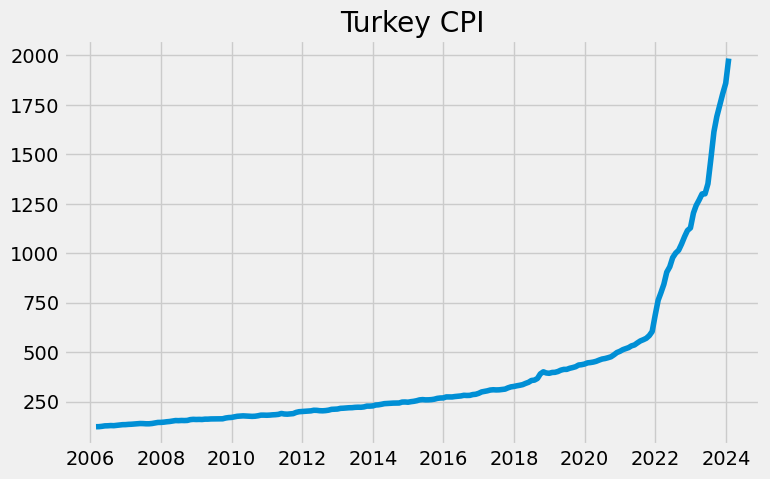

In [9]:
dates=pd.date_range(start="2006-02-28",periods=len(enf) , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [10]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.074857


In [11]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
del money["YEARWEEK"]
money=pd.DataFrame(money)
money.columns=["Tarih","Para Arzi"]
money=money.set_index(pd.to_datetime(money["Tarih"], format='%d-%m-%Y'))
del money["Tarih"]
money=money.resample('M').last()
money=money.pct_change(1)*100
money=money.dropna()
money

,Para Arzi
Tarih,
2006-02-28,2.121748
2006-03-31,2.927613
2006-04-30,1.084694
2006-05-31,9.121170
2006-06-30,1.433197
...,...
2023-10-31,3.356297
2023-11-30,2.245991
2023-12-31,4.333376


In [12]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
Tarih,
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-10-31,130.934676
2023-11-30,134.161244
2023-12-31,140.183543


In [13]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",periods=len(issizlik),freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-07-31,9.3
2023-08-31,9.1
2023-09-30,9.0
2023-10-31,8.5


In [14]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2023-10-31,88.704091
2023-11-30,82.027727
2023-12-31,77.324000


In [15]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
del kredi["Tarih"]
del kredi["YEARWEEK"]
kredi=kredi.set_index(pd.date_range(start="2006-02-03",periods=len(kredi),freq="W"))
kredi.columns=["Kredi"]
kredi=(kredi.pct_change(4)*100).dropna()
kredi=kredi.resample('M').last()
kredi

,Kredi
2006-03-31,4.327119
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.364474
2006-07-31,-0.493205
...,...
2023-10-31,2.154973
2023-11-30,2.932091
2023-12-31,2.873464
2024-01-31,1.789324


In [16]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-03-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-03-28',periods=len(df3) , freq='1M'))
df3

,Kredi
2006-03-31,4.327119
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.364474
2006-07-31,-0.493205
...,...
2023-10-31,2.154973
2023-11-30,2.932091
2023-12-31,2.873464
2024-01-31,1.789324


In [17]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
212,2023-10,33.00
213,2023-11,41.09
214,2023-12,42.50
215,2024-1,44.00


In [18]:
dates=pd.date_range('2006-02-28',periods=len(pfaiz) , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-10-31,33.00
2023-11-30,41.09
2023-12-31,42.50


In [19]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del kfaiz["Tarih"]
del kfaiz["YEARWEEK"]
kfaiz=kfaiz.set_index(pd.date_range(start="2006-02-01",periods=len(kfaiz),freq="1W"))
kfaiz=kfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])
kfaiz.columns=["Kredi Faizi"]
kfaiz

,Kredi Faizi
2006-02-28,17.02
2006-03-31,16.88
2006-04-30,15.84
2006-05-31,16.60
2006-06-30,20.35
...,...
2023-10-31,58.43
2023-11-30,58.61
2023-12-31,58.16
2024-01-31,59.41


In [20]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",periods=len(perakende1),freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-06-30,180.070938,186.192371,179.437348
2023-07-31,191.652101,194.142558,184.796934
2023-08-31,185.107822,183.341634,176.289202
2023-09-30,184.891859,183.368030,175.221191


In [21]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",periods=len(motorin),freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-10-31,38.900000
2023-11-30,37.680000
2023-12-31,36.420000
2024-01-31,39.450000


In [22]:
sanayi=pd.read_excel("./sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-07-31,147.426310
2023-08-31,146.188629
2023-09-30,146.015076
2023-10-31,145.634666


In [23]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="03-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
#mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2024-01-01",freq="1M"))
del mfaiz["YEARWEEK"]
del mfaiz["Tarih"]
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-03",periods=len(mfaiz),freq="W"))
mfaiz=mfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])

mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.70
2006-03-31,14.84
2006-04-30,14.87
2006-05-31,14.84
2006-06-30,15.57
...,...
2023-10-31,41.72
2023-11-30,46.07
2023-12-31,52.50
2024-01-31,49.61


In [24]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",periods=len(enf_belirsizlik),freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-09-30,7.30
2023-10-31,5.57
2023-11-30,4.49
2023-12-31,3.36


In [25]:
borc=evds.get_data(["TP.KB.A09"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2006-01-01",periods=len(borc),freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2006-01-31,2.435600e+08
2006-02-28,2.464270e+08
2006-03-31,2.463600e+08
2006-04-30,2.466640e+08
2006-05-31,2.507320e+08
...,...
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.086466e+09


In [26]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",periods=len(redk),freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-09-30,89.21
2023-10-31,89.10
2023-11-30,87.36
2023-12-31,85.93


In [27]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",periods=len(redkt),freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-09-30,55.53
2023-10-31,56.05
2023-11-30,55.27
2023-12-31,55.29


In [28]:
data=pd.DataFrame()
data["USD/TL"]=df6["USD/TL"].rolling(3).mean()
#data["USD/TL2"]=df6["USD/TL"]
#data["USD/TL3"]=df6["USD/TL"]**2
#data["USD/TL4"]=df6["USD/TL"]**3
#data["USD/TL5"]=df6["USD/TL"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["Borç"]=(borc["Borç"]).shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change()*100
data

,USD/TL,Motorin,Perakende Satış,Sanayi,M3,Borç,TÜFE
Tarih,,,,,,,
2006-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-31,NaN,0.975610,NaN,2.437308,NaN,1.177123,0.274548
2006-04-30,NaN,2.898551,NaN,-0.738864,2.564688,-0.027189,1.336769
2006-05-31,2.353679,4.694836,NaN,0.882710,1.323922,0.123397,1.875397
2006-06-30,6.483947,5.829596,NaN,0.536906,9.308200,1.649207,0.335413
...,...,...,...,...,...,...,...
2023-10-31,1.709911,-0.714650,1.976717,-0.260527,2.614384,3.653039,3.433981
2023-11-30,2.001541,-3.136247,0.000000,-1.421973,3.374057,3.741984,3.281097
2023-12-31,2.498315,-3.343949,0.000000,0.000000,2.464258,4.034830,2.927207


In [29]:

data["Kredi"]=df3["Kredi"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["Zam"]=0
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data=data[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','İşsizlik','Politika Faizi','TÜFE']]
data.iloc[11:23,4]=12.3
data.iloc[23:35,4]=29.32
data.iloc[35:47,4]=7.92
data.iloc[47:59,4]=14.17
data.iloc[59:71,4]=25.45
data.iloc[71:83,4]=15
data.iloc[83:95,4]=8
data.iloc[95:107,4]=846
data.iloc[107:119,4]=949.07
data.iloc[119:131,4]=1300.99
data.iloc[131:143,4]=1404.6
data.iloc[143:155,4]=1603.12
data.iloc[155:167,4]=2020.59
data.iloc[167:179,4]=2324.70
data.iloc[179:191,4]=2825.90
data.iloc[191:197,4]=4253.40
data.iloc[197:203,4]=5500.35
data.iloc[203:209,4]=8506.80
data.iloc[209:,4]=11402.32
data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)
data=data.loc["2014-01-31":"2024-01-31"]
data.iloc[0,4]=14.2
data

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.80,14.2,3.604096,0.82,3.375162,-0.584687,2.669930,8.85,91.32,95.75,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.54,0.0,-0.850238,0.73,1.804994,0.808574,1.876850,10.75,93.31,96.63,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,16.05,0.0,0.128936,0.80,0.451349,0.193691,0.822203,11.65,93.75,97.25,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.65,0.0,-0.863760,0.73,0.796760,0.478162,-0.154556,10.75,98.14,102.98,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.36,0.0,-1.367417,0.80,-0.362357,0.091080,0.146305,10.43,99.40,105.10,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,5.071342,4.843457,-0.605829,57.56,0.0,-0.118719,7.30,4.764088,4.384930,2.048237,42.74,89.21,55.53,9.0,31.00,4.753114
2023-10-31,1.709911,-0.714650,1.976717,58.43,0.0,-0.260527,5.57,2.694232,3.653039,1.782758,41.72,89.10,56.05,8.5,33.00,3.433981
2023-11-30,2.001541,-3.136247,0.000000,58.61,0.0,-1.421973,4.49,3.356297,3.741984,2.499767,46.07,87.36,55.27,9.0,41.09,3.281097


In [30]:
data1=data[:-2]

In [31]:
data1=data1.diff()
data1=data1.dropna()

<Axes: title={'center': 'TÜFE ile Korelasyonlar'}>

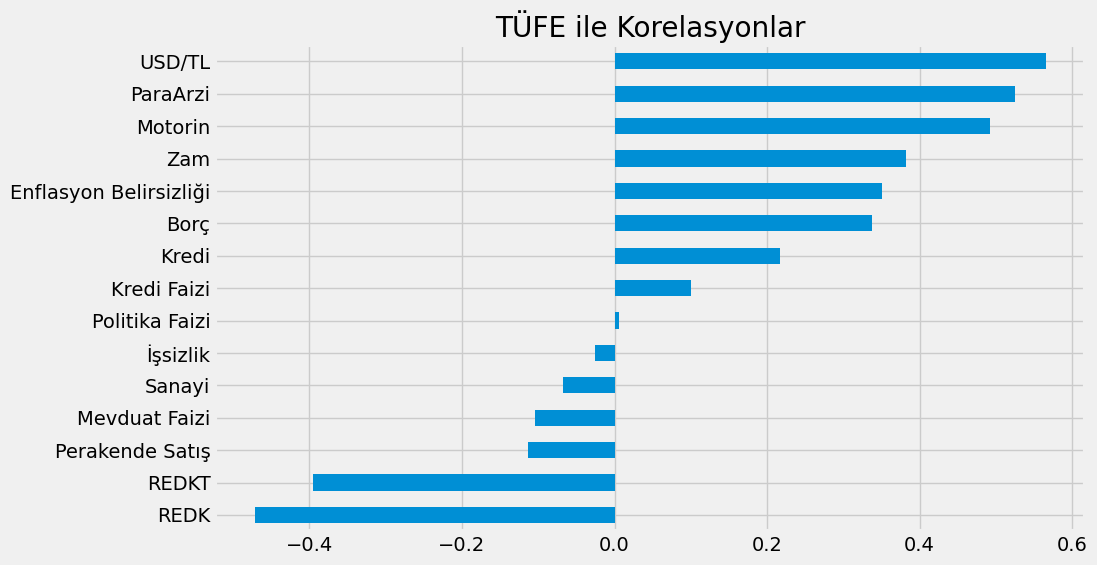

In [32]:
cor_matrix=data1.corr()
cor_matrix=(cor_matrix["TÜFE"]).sort_values(ascending=True)
cor_matrix[:-1].plot(kind="barh",title="TÜFE ile Korelasyonlar",figsize=(10,6))

In [33]:
data=data.drop(["Perakende Satış","Kredi Faizi","Sanayi"],axis=1)

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
s=seasonal_decompose(data["TÜFE"],model="additive")
düzeltilmiştüfe=data["TÜFE"]-s.seasonal
düzeltilmiştüfe.tail(12)

Tarih
2023-02-28    3.588343
2023-03-31    2.576378
2023-04-30    2.048631
2023-05-31    0.840929
2023-06-30    4.210212
2023-07-31    9.474650
2023-08-31    9.817964
2023-09-30    4.708619
2023-10-31    2.816910
2023-11-30    3.691900
2023-12-31    2.469322
2024-01-31    5.214077
Freq: M, dtype: float64

In [35]:
model=auto_arima(pfaiz["Politika Faizi"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[-8:,0]},index=pd.date_range(start="2023-08-30",periods=7,freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin.iloc[4:,0]=[42.5,45,45,45,45,45,45,45,45,45,42.5,40,37.5,35,35,35,35,35,35,35,32.5,30,27.5,25,25,25,25,25]
faiztahmin

,Politika Faizi
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00
2023-11-30,41.09
2023-12-31,42.50
2024-01-31,45.00
2024-02-29,45.00
2024-03-31,45.00
2024-04-30,45.00
2024-05-31,45.00


In [36]:
model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,X=np.array(pfaiz["Politika Faizi"]).reshape(-1,1),information_criterion="aic",m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(25,X=np.array(faiztahmin["Politika Faizi"][7:]).reshape(-1,1))
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[211:,0]},index=kfaiz.index[211:])
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-09-30,57.560000
2023-10-31,58.430000
2023-11-30,58.610000
2023-12-31,58.160000
2024-01-31,59.410000
2024-02-29,59.630000
2024-03-31,59.935533
2024-04-30,60.570724
2024-05-31,61.086922
2024-06-30,61.232537


In [37]:
trainexog=kfaiz[47:-2]
trainexog

,Kredi Faizi
2010-01-31,13.76
2010-02-28,13.36
2010-03-31,13.10
2010-04-30,13.18
2010-05-31,13.25
...,...
2023-08-31,45.29
2023-09-30,57.56
2023-10-31,58.43
2023-11-30,58.61


In [38]:
testexog=kfaiztahmin[2:]
testexog

,Kredi Faizi
2023-11-30,58.610000
2023-12-31,58.160000
2024-01-31,59.410000
2024-02-29,59.630000
2024-03-31,59.935533
2024-04-30,60.570724
2024-05-31,61.086922
2024-06-30,61.232537
2024-07-31,61.035046
2024-08-31,60.704225


In [39]:
faiztahmin[5:]

,Politika Faizi
2024-01-31,45.0
2024-02-29,45.0
2024-03-31,45.0
2024-04-30,45.0
2024-05-31,45.0
2024-06-30,45.0
2024-07-31,45.0
2024-08-31,45.0
2024-09-30,45.0
2024-10-31,42.5


In [40]:
model=auto_arima(mfaiz["Mevduat Faizi"],X=pfaiz,trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(26,X=faiztahmin[6:]))
mfaiztahmin.columns=["Mevduat Faizi"]
row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-2:,0]},index=pd.date_range(start="2024-01-30",periods=2,freq="1M"))
mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin


,Mevduat Faizi
2024-01-31,49.610000
2024-02-29,50.990000
2024-03-31,53.966782
2024-04-30,51.572234
2024-05-31,51.518637
2024-06-30,53.195784
2024-07-31,51.848090
2024-08-31,51.816723
2024-09-30,52.761643
2024-10-31,52.003137


In [41]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [42]:
exog=pd.DataFrame()
exog["X"]=usd["TP_DK_USD_S_YTL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2023-10-31,2432.069312
2023-11-30,2316.594077
2023-12-31,2231.258978
2024-01-31,2340.028073


In [43]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,25]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [44]:
faiztahmin.columns=["Faiz"]


In [45]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [46]:
exog=pfaiz["Politika Faizi"].iloc[95:-3]
exog=np.array(exog).reshape(-1,1)

In [47]:
exogtest=faiztahmin.iloc[4:]
exogtest=np.array(exogtest).reshape(-1,1)

In [48]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(28,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2023-12-31,9.031995
2024-01-31,8.928669
2024-02-29,9.141120
2024-03-31,9.201787
2024-04-30,9.221023
2024-05-31,9.328421
2024-06-30,9.388207
2024-07-31,9.433416
2024-08-31,9.502816
2024-09-30,9.556027


In [49]:
from prophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [50]:
df6.shape

(217, 1)

In [51]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 50),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,50),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6[:-12].index
    sn["y"]=df6[:-12].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df6[-12:].values,predictions["yhat"][-12:])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')
"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 50),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,50),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df6[:-12].index\n    sn["y"]=df6[:-12].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params[

In [52]:
"""study.best_params"""

'study.best_params'

In [53]:
sn=pd.DataFrame()
sn["ds"]=df6.index
sn["y"]=df6.values
prophet=Prophet(growth="linear",changepoint_prior_scale=7.495807516055437,changepoint_range=0.9731904611246964,seasonality_prior_scale=7.717380426245633,n_changepoints=90,interval_width=0.70,mcmc_samples=50)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=14,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:05:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:43 - cmdstanpy - INFO - CmdStan done processing.
19:05:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
19:05:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 21 divergent transitions (84.0%)
	Chain 1 had 4 iterations at max treedepth (16.0%)
	Chain 2 had 25 divergent transitions (100.0%)
	Chain 3 had 25 diverg

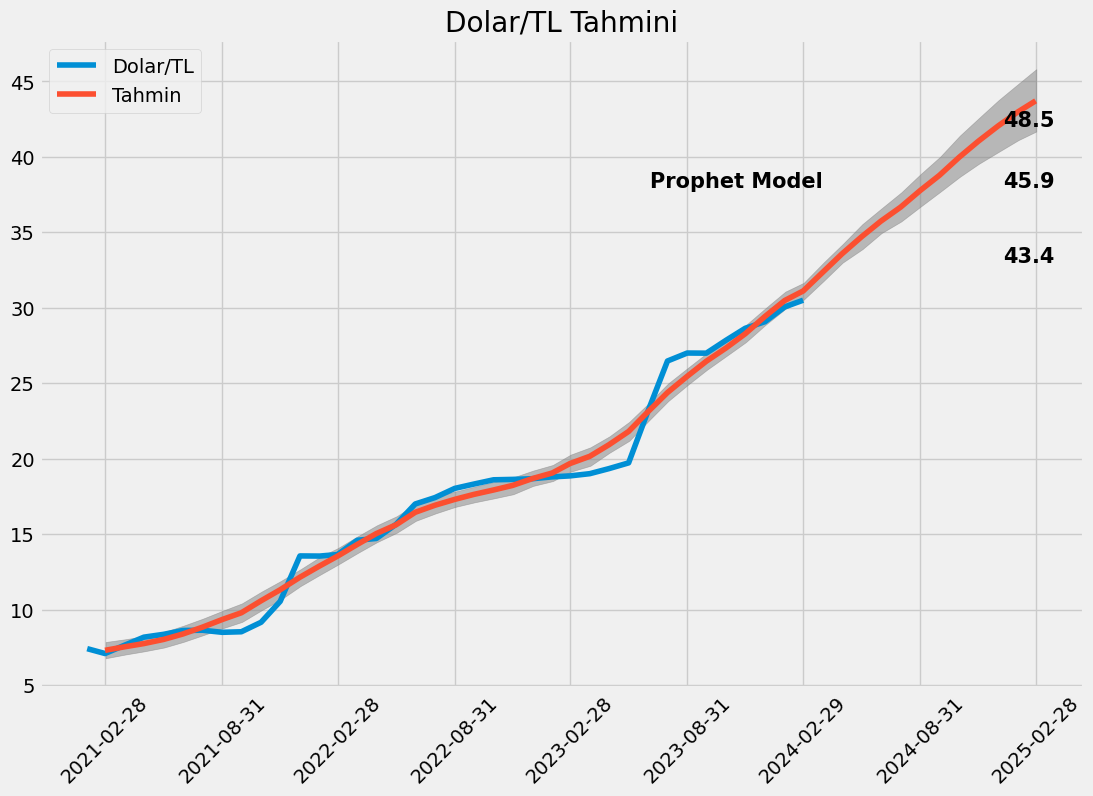

In [54]:
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
plt.plot(df6["USD/TL"][-38:],label='Dolar/TL')
plt.plot(predictions["yhat"][-51:-2],label='Tahmin')
annotation_date = mdates.datestr2num('2025-03-30')
annotation_date1 = mdates.datestr2num('2024-03-30')
plt.text(annotation_date1, 38,  "Prophet Model",fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 38,  str(predictions["yhat"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 33,  str(predictions["yhat_lower"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 42,  str(predictions["yhat_upper"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.fill_between(predictions["yhat"][-51:-1].index.strftime("%Y-%m"), predictions["yhat_upper"][-51:-1].shift(1), predictions["yhat_lower"][-51:-1].shift(1), alpha=0.5, color='gray')
plt.xticks(predictions.index[-51:-2:6],rotation=45)
plt.title('Dolar/TL Tahmini')
plt.legend(loc=2)

In [55]:
usdtahmin=(predictions["yhat"][-16:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2024-02-29    2.071668
2024-03-31    4.026425
2024-04-30    3.739030
2024-05-31    3.395076
2024-06-30    2.951817
2024-07-31    2.600151
2024-08-31    3.030231
2024-09-30    2.649104
2024-10-31    3.085461
2024-11-30    2.652330
2024-12-31    2.460834
2025-01-31    2.213283
2025-02-28    1.712832
2025-03-31    2.626869
2025-04-30    2.437294
Name: yhat, dtype: float64

In [56]:
usdtahmin1 = []
result = df6.iloc[-2,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([df6.iloc[-6:-1],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-09-30", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.074857
2024-01-31,30.053750
2024-02-29,30.676364
2024-03-31,31.911525
2024-04-30,33.104706
2024-05-31,34.228636
2024-06-30,35.239003


In [57]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[50:].index\n    sn["y"]=df14[50:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = optuna.create_study(direction=

In [58]:
"""study.best_params"""

'study.best_params'

In [59]:
sn=pd.DataFrame()
sn["ds"]=df14[50:].index
sn["y"]=df14[50:].values
prophet=Prophet(growth="linear",changepoint_prior_scale=8.441645091305189,changepoint_range=0.9896533088928638,seasonality_prior_scale=6.984796984939141,n_changepoints=96)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:05:45 - cmdstanpy - INFO - Chain [1] start processing
19:05:45 - cmdstanpy - INFO - Chain [1] done processing


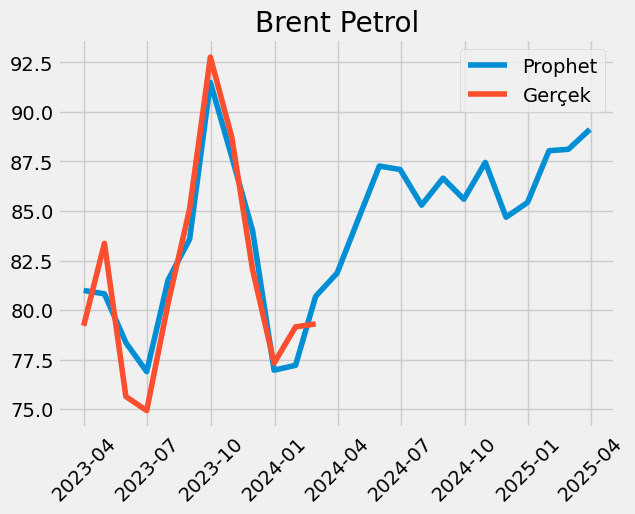

In [60]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-25:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [61]:
brenttahmin=predictions["yhat"][-17:]
brenttahmin

ds
2023-11-30    83.994937
2023-12-31    76.965540
2024-01-31    77.210947
2024-02-29    80.691595
2024-03-31    81.865345
2024-04-30    84.534681
2024-05-31    87.267879
2024-06-30    87.094025
2024-07-31    85.296644
2024-08-31    86.656730
2024-09-30    85.595645
2024-10-31    87.452729
2024-11-30    84.686618
2024-12-31    85.429819
2025-01-31    88.040738
2025-02-28    88.114018
2025-03-31    89.118916
Name: yhat, dtype: float64

In [62]:
"""brenttahmin=pd.read_csv("C:/Users/Bora/Downloads/brent_forecast.csv")
brenttahmin=brenttahmin.set_index(brenttahmin["Unnamed: 0"])
del brenttahmin["Unnamed: 0"]
brenttahmin.index.name="" 
brenttahmin"""

'brenttahmin=pd.read_csv("C:/Users/Bora/Downloads/brent_forecast.csv")\nbrenttahmin=brenttahmin.set_index(brenttahmin["Unnamed: 0"])\ndel brenttahmin["Unnamed: 0"]\nbrenttahmin.index.name="" \nbrenttahmin'

In [63]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.80),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik[40:].index
    sn["y"]=enf_belirsizlik[40:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.80),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik[40:].index\n    sn["y"]=enf_belirsizlik[40:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\

In [64]:
"""study.best_params"""

'study.best_params'

19:05:46 - cmdstanpy - INFO - Chain [1] start processing
19:05:46 - cmdstanpy - INFO - Chain [1] done processing


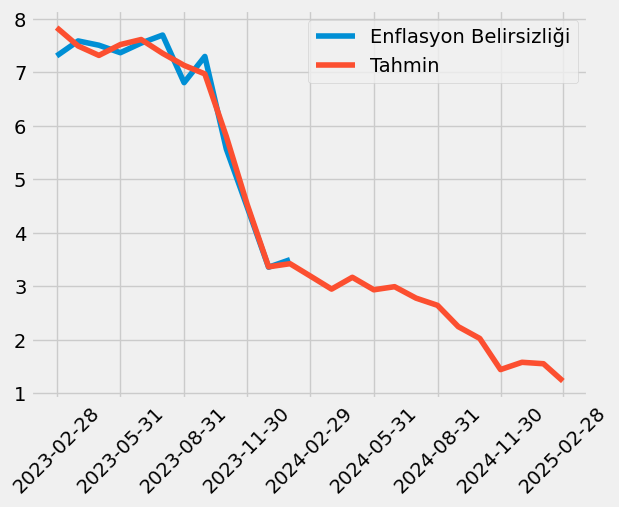

In [65]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=17.95210046456901,changepoint_range=0.9993099781087834,seasonality_prior_scale=6.849099847065717,n_changepoints=44,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()


In [66]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-15:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0]=3.36
enfbelirsizliktahmin1.iloc[1]=3.5
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2023-12-31,3.360000
2024-01-31,3.500000
2024-02-29,3.196880
2024-03-31,2.950193
2024-04-30,3.170942
2024-05-31,2.937366
2024-06-30,2.995336
2024-07-31,2.781375
2024-08-31,2.646703


In [67]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [68]:
#study.best_params

In [69]:
sn=pd.DataFrame()
sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].index
sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].values
sn["cap"]=190
prophet=Prophet(changepoint_prior_scale=3.481321992729419,changepoint_range=0.8995930316928846,growth='linear',seasonality_prior_scale=8.977376335194005,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=190
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:05:47 - cmdstanpy - INFO - Chain [1] start processing
19:05:47 - cmdstanpy - INFO - Chain [1] done processing


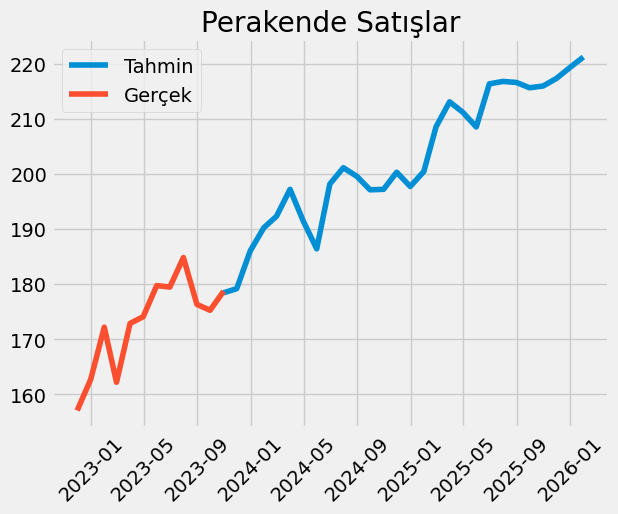

In [70]:
plt.title("Perakende Satışlar")
plt.plot(predictions["yhat"][-28:],label="Tahmin")
plt.plot(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [71]:
perakendetahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
perakendetahmin

ds
2023-11-30    0.417766
2023-12-31    3.837414
2024-01-31    2.255112
2024-02-29    1.093496
2024-03-31    2.545369
2024-04-30   -2.901185
2024-05-31   -2.657283
2024-06-30    6.315988
2024-07-31    1.493700
2024-08-31   -0.782232
2024-09-30   -1.221874
2024-10-31    0.044657
2024-11-30    1.575699
2024-12-31   -1.293369
2025-01-31    1.373530
2025-02-28    4.050079
2025-03-31    2.179169
2025-04-30   -0.886073
2025-05-31   -1.268685
2025-06-30    3.756526
2025-07-31    0.201727
2025-08-31   -0.087168
2025-09-30   -0.445215
2025-10-31    0.148098
2025-11-30    0.628616
2025-12-31    0.911598
2026-01-31    0.878391
Name: yhat, dtype: float64

In [72]:
((usdtahmin1[2:-1].pct_change(periods=1)*100).dropna())

,USD/TL
2023-12-31,1.528701
2024-01-31,3.366802
2024-02-29,2.071668
2024-03-31,4.026425
2024-04-30,3.739030
2024-05-31,3.395076
2024-06-30,2.951817
2024-07-31,2.600151
2024-08-31,3.030231
2024-09-30,2.649104


In [73]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

ds
2023-12-31   -8.368833
2024-01-31    0.318852
2024-02-29    4.507973
2024-03-31    1.454612
2024-04-30    3.260643
2024-05-31    3.233226
2024-06-30   -0.199219
2024-07-31   -2.063724
2024-08-31    1.594536
2024-09-30   -1.224469
2024-10-31    2.169601
2024-11-30   -3.162978
2024-12-31    0.877590
2025-01-31    3.056215
2025-02-28    0.083234
2025-03-31    1.140452
Name: yhat, dtype: float64

In [74]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[2:-1].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2023-12-30",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2023-12-31,5.678074
2024-01-31,3.696389
2024-02-29,6.673031
2024-03-31,5.539606
2024-04-30,7.121590
2024-05-31,6.738072
2024-06-30,2.746717
2024-07-31,0.482767
2024-08-31,4.673085
2024-09-30,1.392198


In [75]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_rang

In [76]:
"""study.best_params"""

'study.best_params'

In [77]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
prophet=Prophet(changepoint_prior_scale=4.9385825316091445,changepoint_range=0.9538315586393957,growth='linear',seasonality_prior_scale=4.314940386271349,n_changepoints=76,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:05:48 - cmdstanpy - INFO - Chain [1] start processing
19:05:48 - cmdstanpy - INFO - Chain [1] done processing


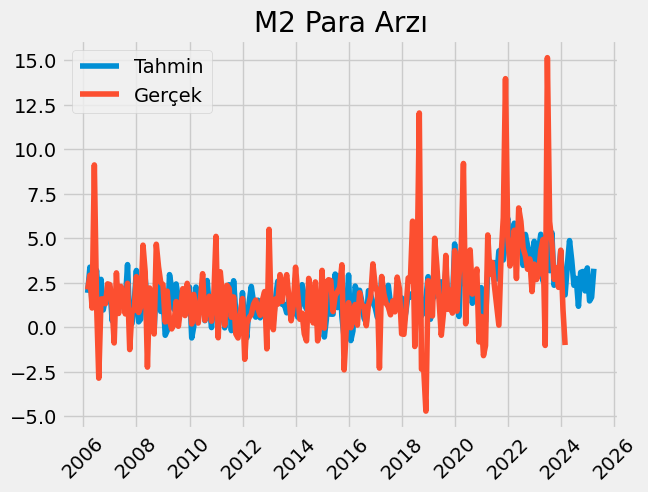

In [78]:
plt.title("M2 Para Arzı")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(money["Para Arzi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [79]:
paraarzitahmin=(predictions["yhat"]).tail(14)
paraarzitahmin

ds
2024-02-29    1.823583
2024-03-31    3.493304
2024-04-30    4.873472
2024-05-31    3.740738
2024-06-30    2.360066
2024-07-31    2.748199
2024-08-31    1.183187
2024-09-30    3.085546
2024-10-31    3.136018
2024-11-30    2.046074
2024-12-31    3.334821
2025-01-31    1.482624
2025-02-28    1.686012
2025-03-31    3.291038
Name: yhat, dtype: float64

In [80]:
paraarzitahmin1 = paraarzitahmin
paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-02-28", periods=len(paraarzitahmin), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-4:-1,0]},index=pd.date_range(start="2023-11-30",periods=3,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
paraarzitahmin1

,Para Arzi
2023-11-30,2.245991
2023-12-31,4.333376
2024-01-31,0.992113
2024-02-29,1.823583
2024-03-31,3.493304
2024-04-30,4.873472
2024-05-31,3.740738
2024-06-30,2.360066
2024-07-31,2.748199
2024-08-31,1.183187


In [81]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [82]:
#study.best_params

In [83]:
sn=pd.DataFrame()
sn["ds"]=borc["Borç"][103:].index
sn["y"]=borc["Borç"][103:].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=3.671534257218686,changepoint_range=0.8995013103592469,growth='linear',seasonality_prior_scale=4.464356522636207,n_changepoints=2)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=26,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:05:49 - cmdstanpy - INFO - Chain [1] start processing
19:05:49 - cmdstanpy - INFO - Chain [1] done processing


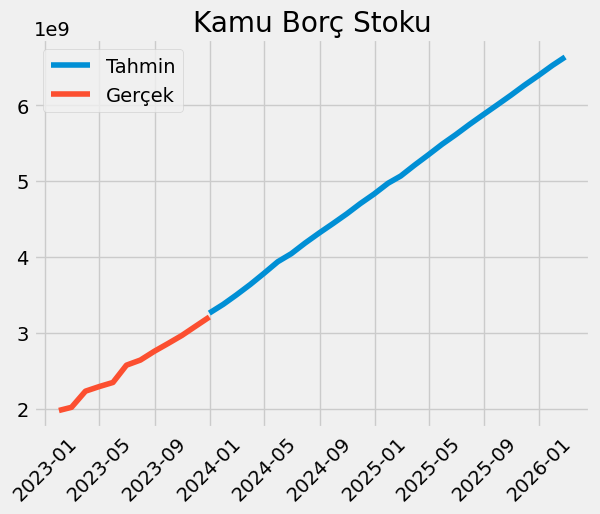

In [84]:
plt.title("Kamu Borç Stoku")
plt.plot(predictions["yhat"][-27:],label="Tahmin")
plt.plot(borc["Borç"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [85]:
borctahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(26)
borctahmin

ds
2024-01-31    3.549683
2024-02-29    3.641687
2024-03-31    3.952185
2024-04-30    3.974986
2024-05-31    4.087029
2024-06-30    2.691098
2024-07-31    3.494913
2024-08-31    3.137333
2024-09-30    2.820024
2024-10-31    2.915254
2024-11-30    2.952763
2024-12-31    2.718657
2025-01-31    2.932624
2025-02-28    1.902385
2025-03-31    2.850371
2025-04-30    2.554249
2025-05-31    2.642735
2025-06-30    2.279607
2025-07-31    2.435279
2025-08-31    2.266843
2025-09-30    2.116154
2025-10-31    2.167006
2025-11-30    2.144938
2025-12-31    2.035404
2026-01-31    2.078257
2026-02-28    1.680028
Name: yhat, dtype: float64

In [86]:
borctahmin1 = []
result = borc.iloc[-1,0]
for i in range(len(borctahmin)):
    result *= (1 + borctahmin[i] / 100)
    borctahmin1.append(result)

borctahmin1 = np.array(borctahmin1).reshape(-1, 1)
borctahmin1 = pd.DataFrame(borctahmin1)
borctahmin1.columns = ["Borç"]
borctahmin1 = borctahmin1.set_index(pd.date_range(start="2024-01-30", periods=len(borctahmin1), freq="1M"))
row=pd.DataFrame({"Borç":borc.iloc[-4:,0]},index=pd.date_range(start="2023-09-30",periods=4,freq="1M"))
borctahmin1=pd.concat([row,borctahmin1],axis=0)
borctahmin1

,Borç
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.086466e+09
2023-12-31,3.209252e+09
2024-01-31,3.323170e+09
2024-02-29,3.444190e+09
2024-03-31,3.580310e+09
2024-04-30,3.722627e+09
2024-05-31,3.874772e+09
2024-06-30,3.979046e+09


In [87]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 15),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,15),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3.values,predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 15),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,15),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growt

In [88]:
"""study.best_params"""

'study.best_params'

In [89]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi"].index
sn["y"]=df3["Kredi"].values
prophet=Prophet(changepoint_prior_scale=14.571144908454663,changepoint_range=0.8904873855141803,growth="linear",seasonality_prior_scale=1.5574317873100854,n_changepoints=192,yearly_seasonality=True,weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:05:50 - cmdstanpy - INFO - Chain [1] start processing
19:05:51 - cmdstanpy - INFO - Chain [1] done processing


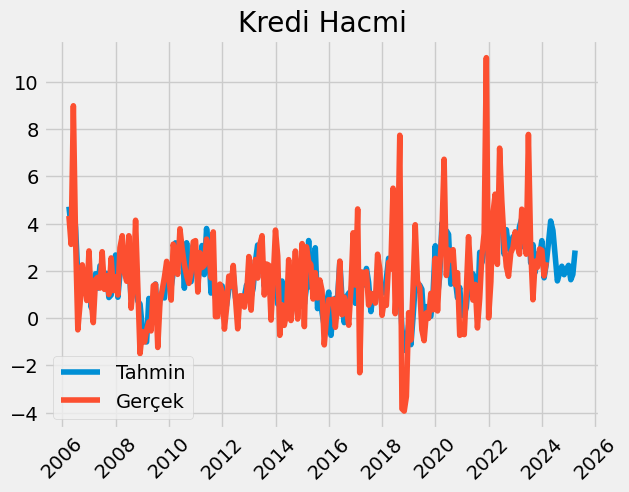

In [90]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(df3["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [91]:
kreditahmin=(predictions["yhat"]).tail(13)
kreditahmin

ds
2024-03-31    3.188663
2024-04-30    4.114421
2024-05-31    3.713324
2024-06-30    2.660927
2024-07-31    1.578028
2024-08-31    1.923114
2024-09-30    2.199623
2024-10-31    1.841386
2024-11-30    2.065446
2024-12-31    2.237099
2025-01-31    1.628708
2025-02-28    1.855005
2025-03-31    2.866806
Name: yhat, dtype: float64

In [92]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-03-31", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":df3.iloc[-4:,0]},index=pd.date_range(start="2023-11-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2023-11-30,2.932091
2023-12-31,2.873464
2024-01-31,1.789324
2024-02-29,2.370812
2024-03-31,3.188663
2024-04-30,4.114421
2024-05-31,3.713324
2024-06-30,2.660927
2024-07-31,1.578028
2024-08-31,1.923114


In [93]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,200),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index
    sn["y"]=m3["M3 Para Arzi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3 Para Arzi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,200),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index\n    sn["y"]=m3["M3 Para Arzi"][

In [94]:
#study.best_params

In [95]:
sn=pd.DataFrame()
sn["ds"]=m3["M3 Para Arzi"][151:].index
sn["y"]=m3["M3 Para Arzi"][151:].values
sn["cap"]=386.728728252815
prophet=Prophet(changepoint_prior_scale=1.0239522189165728,changepoint_range=0.8631788185438879,growth='logistic',seasonality_prior_scale=8.271825948806738,n_changepoints=14,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=386.728728252815
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:05:52 - cmdstanpy - INFO - Chain [1] start processing
19:05:53 - cmdstanpy - INFO - Chain [1] done processing


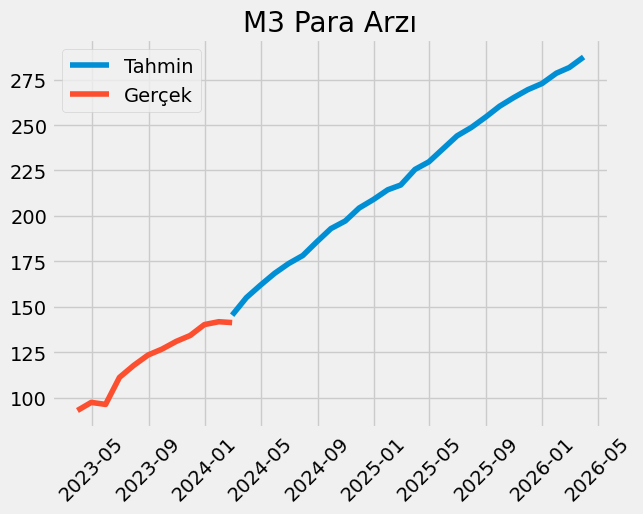

In [96]:
plt.title("M3 Para Arzı")
plt.plot(predictions["yhat"][-26:],label="Tahmin")
plt.plot(m3["M3 Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [97]:
m3tahmin=(predictions["yhat"].tail(26).pct_change(periods=1)*100).dropna()
m3tahmin1 = []
result = m3.iloc[-1,0]
for i in range(len(m3tahmin)):
    result *= (1 + m3tahmin[i] / 100)
    m3tahmin1.append(result)

m3tahmin1 = np.array(m3tahmin1).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-02-28", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2023-10-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2023-10-31,NaN
2023-11-30,134.161244
2023-12-31,140.183543
2024-01-31,141.753265
2024-02-29,150.710039
2024-03-31,157.256265
2024-04-30,163.668675
2024-05-31,168.853216
2024-06-30,173.196999
2024-07-31,180.678231


In [98]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [99]:
#study.best_params

In [100]:
sn=pd.DataFrame()
sn["ds"]=sanayi["Sanayi"].index
sn["y"]=sanayi["Sanayi"].values
prophet=Prophet(changepoint_prior_scale=9.619978429571834,changepoint_range=0.8872026398316396,growth='linear',seasonality_prior_scale=4.66384076344283,n_changepoints=25,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:05:54 - cmdstanpy - INFO - Chain [1] start processing
19:05:54 - cmdstanpy - INFO - Chain [1] done processing


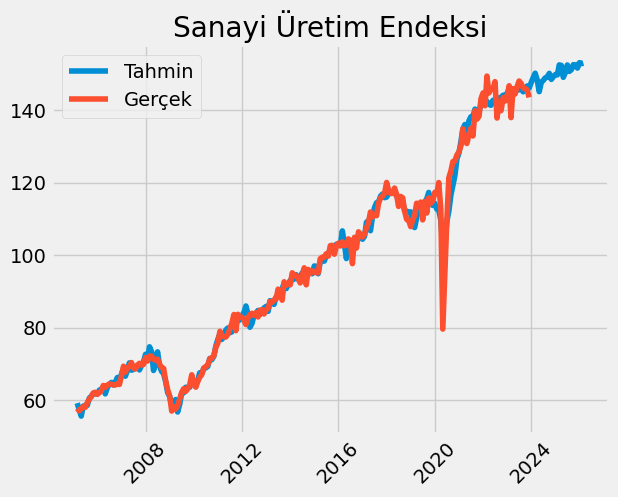

In [101]:
plt.title("Sanayi Üretim Endeksi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(sanayi["Sanayi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [102]:
sanayitahmin=(predictions["yhat"].tail(27).pct_change(periods=1)*100).dropna()
sanayitahmin1 = []
result = sanayi.iloc[-1,0]
for i in range(len(sanayitahmin)):
    result *= (1 + sanayitahmin[i] / 100)
    sanayitahmin1.append(result)

sanayitahmin1 = np.array(sanayitahmin1).reshape(-1, 1)
sanayitahmin1 = pd.DataFrame(sanayitahmin1)
sanayitahmin1.columns = ["Sanayi"]
sanayitahmin1 = sanayitahmin1.set_index(pd.date_range(start="2023-12-30", periods=len(sanayitahmin1), freq="1M"))
#row=pd.DataFrame({"Sanayi":df3.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",periods=2,freq="1M"))
#sanayitahmin1=pd.concat([row,sanayitahmin1],axis=0)
sanayitahmin1

,Sanayi
2023-12-31,144.902218
2024-01-31,146.030496
2024-02-29,144.210225
2024-03-31,141.080420
2024-04-30,143.596436
2024-05-31,144.089681
2024-06-30,144.800885
2024-07-31,145.018318
2024-08-31,145.997254
2024-09-30,144.369606


In [103]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"][params["m"]:-36].index
    sn["y"]=redkt["REDKT"][params["m"]:-36].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"][-36:],predictions["yhat"][-36:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"][params["m"]:-36].index\n    sn["y"]=redkt["REDKT"][params[

In [104]:
#study.best_params

In [105]:
sn=pd.DataFrame()
sn["ds"]=redkt["REDKT"].index
sn["y"]=redkt["REDKT"].values
sn["cap"]=300
prophet=Prophet(changepoint_prior_scale=4.998474885835357,
 changepoint_range=0.8719913329652468,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=300
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:05:55 - cmdstanpy - INFO - Chain [1] start processing
19:05:55 - cmdstanpy - INFO - Chain [1] done processing


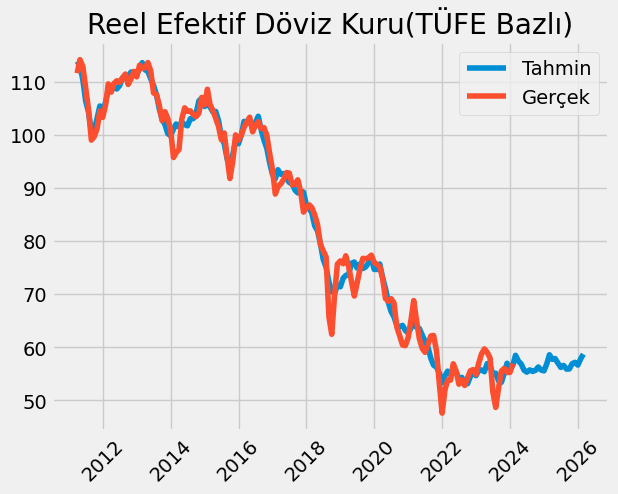

In [106]:
plt.title("Reel Efektif Döviz Kuru(TÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redkt["REDKT"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [107]:
predictions["yhat"].tail(26)

ds
2024-01-31    56.640100
2024-02-29    58.505198
2024-03-31    57.417650
2024-04-30    56.866533
2024-05-31    55.688714
2024-06-30    55.337045
2024-07-31    55.762017
2024-08-31    55.475035
2024-09-30    55.670413
2024-10-31    56.308064
2024-11-30    55.729598
2024-12-31    55.578815
2025-01-31    56.927392
2025-02-28    58.611467
2025-03-31    57.755819
2025-04-30    57.894979
2025-05-31    57.017113
2025-06-30    56.233545
2025-07-31    56.589685
2025-08-31    55.913466
2025-09-30    55.936030
2025-10-31    56.931289
2025-11-30    57.175237
2025-12-31    56.663824
2026-01-31    57.878159
2026-02-28    58.719425
Name: yhat, dtype: float64

In [108]:
redkttahmin=predictions["yhat"].tail(26)
redkttahmin=pd.DataFrame(redkttahmin)
redkttahmin.columns=["REDKT"]
redkttahmin=redkttahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redkttahmin.iloc[0,0]=redkt.iloc[-1,0]
redkttahmin

,REDKT
2023-12-31,56.950000
2024-01-31,58.505198
2024-02-29,57.417650
2024-03-31,56.866533
2024-04-30,55.688714
2024-05-31,55.337045
2024-06-30,55.762017
2024-07-31,55.475035
2024-08-31,55.670413
2024-09-30,56.308064


In [109]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redk["REDK"].index
    sn["y"]=redk["REDK"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-13))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redk["REDK"].index\n    sn["y"]=redk["REDK"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scale=par

In [110]:
sn=pd.DataFrame()
sn["ds"]=redk["REDK"].index
sn["y"]=redk["REDK"].values
prophet=Prophet(changepoint_prior_scale=6.258111900769947,changepoint_range=0.9753144235744484,growth='linear',seasonality_prior_scale=0.16965698744688584,n_changepoints=99,yearly_seasonality=True,weekly_seasonality="auto")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:05:56 - cmdstanpy - INFO - Chain [1] start processing
19:05:57 - cmdstanpy - INFO - Chain [1] done processing


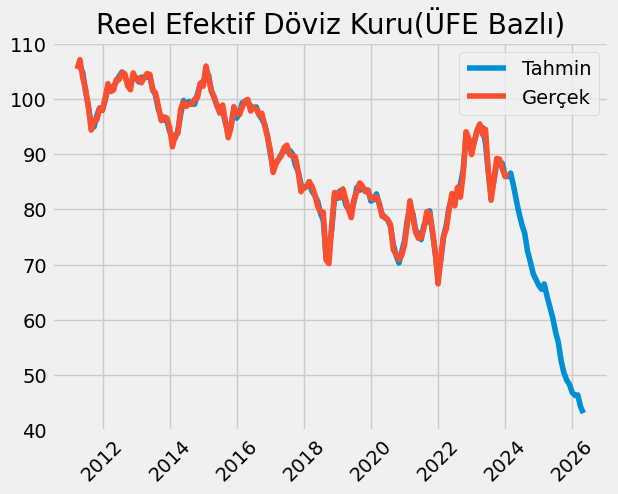

In [111]:
plt.title("Reel Efektif Döviz Kuru(ÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redk["REDK"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [112]:
predictions["yhat"].tail(28)

ds
2024-01-31    85.916264
2024-02-29    86.563648
2024-03-31    84.270804
2024-04-30    81.694536
2024-05-31    79.246497
2024-06-30    77.250735
2024-07-31    75.625077
2024-08-31    72.366635
2024-09-30    70.506671
2024-10-31    68.332527
2024-11-30    67.318063
2024-12-31    66.224301
2025-01-31    65.516070
2025-02-28    66.476094
2025-03-31    64.243414
2025-04-30    62.381958
2025-05-31    60.404861
2025-06-30    57.918311
2025-07-31    55.933331
2025-08-31    52.561945
2025-09-30    50.420743
2025-10-31    49.051611
2025-11-30    48.275913
2025-12-31    46.774946
2026-01-31    46.283765
2026-02-28    46.380136
2026-03-31    44.229643
2026-04-30    43.089729
Name: yhat, dtype: float64

In [113]:
redktahmin=predictions["yhat"].tail(28)
redktahmin=pd.DataFrame(redktahmin)
redktahmin.columns=["REDK"]
redktahmin=redktahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redktahmin),freq="1M"))
redktahmin.iloc[0,0]=redk.iloc[-1,0]
redktahmin

,REDK
2023-12-31,86.530000
2024-01-31,86.563648
2024-02-29,84.270804
2024-03-31,81.694536
2024-04-30,79.246497
2024-05-31,77.250735
2024-06-30,75.625077
2024-07-31,72.366635
2024-08-31,70.506671
2024-09-30,68.332527


In [114]:
motorintahmin.iloc[2]=5.6781
motorintahmin.iloc[1]=8.3196
motorintahmin.iloc[0]=-3.34

In [115]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 2),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.001,1.0),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoinst',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=historical_volatility.index
    sn["y"]=historical_volatility.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 2),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.001,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoinst\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=historical_volatility.index\n    sn["y"]=historical_volatility.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predict

In [116]:
"""study.best_params"""

'study.best_params'

In [117]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean(),sanayitahmin1["Sanayi"],m3tahmin1["M3"].shift(1),borctahmin1.shift(1)],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Para Arzi"]=paraarzitahmin1.shift(1)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].rolling(3).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["REDKT"]=redkttahmin["REDKT"]
tahmindf["REDK"]=redktahmin["REDK"]
#tahmindf["Politika Faizi"]=faiztahmin["Faiz"]
tahmindf["Perakende Satış"]=perakendetahmin




tahmindf["Politika Faizi"]=[42.5,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,42.5,40]
tahmindf=tahmindf[['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDKT','REDK','İşsizlik','Politika Faizi',"Sanayi","Perakende Satış"]]

tahmindf.columns=["USD/TL","Motorin","Kredi Faizi","Zam","Enflasyon Belirsizliği",'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDKT','REDK','İşsizlik','Politika Faizi',"Sanayi","Perakende Satış"]
tahmindf=tahmindf.dropna(axis=0)









#tahmindf.iloc[1,1]=5.0
tahmindf=tahmindf.iloc[1:,:]
tahmindf

,USD/TL,Motorin,Kredi Faizi,Zam,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDKT,REDK,İşsizlik,Politika Faizi,Sanayi,Perakende Satış
2024-02-29,2.323553,5.678100,59.630000,0.0,3.196880,0.992113,3.549683,2.344533,50.990000,57.417650,84.270804,9.141120,45.0,-1.246501,1.093496
2024-03-31,3.158698,5.539606,59.935533,0.0,2.950193,1.823583,3.641687,2.449600,53.966782,56.866533,81.694536,9.201787,45.0,-2.170307,2.545369
2024-04-30,3.293288,7.121590,60.570724,0.0,3.170942,3.493304,3.952185,3.224632,51.572234,55.688714,79.246497,9.221023,45.0,1.783391,-2.901185
2024-05-31,3.712170,6.738072,61.086922,0.0,2.937366,4.873472,3.974986,3.672136,51.518637,55.337045,77.250735,9.328421,45.0,0.343495,-2.657283
2024-06-30,3.352796,2.746717,61.232537,0.0,2.995336,3.740738,4.087029,3.496224,53.195784,55.762017,75.625077,9.388207,45.0,0.493584,6.315988
2024-07-31,2.974060,0.482767,61.035046,0.0,2.781375,2.360066,2.691098,2.650760,51.848090,55.475035,72.366635,9.433416,45.0,0.150160,1.493700
2024-08-31,2.861332,4.673085,60.704225,0.0,2.646703,2.748199,3.494913,2.054023,51.816723,55.670413,70.506671,9.502816,45.0,0.675043,-0.782232
2024-09-30,2.760059,1.392198,60.462536,0.0,2.247916,1.183187,3.137333,1.900255,52.761643,56.308064,68.332527,9.556027,45.0,-1.114849,-1.221874
2024-10-31,2.921981,5.322005,60.418013,0.0,2.027988,3.085546,2.820024,1.988041,52.003137,55.729598,67.318063,9.614859,45.0,0.530569,0.044657
2024-11-30,2.795419,-0.594541,60.537760,0.0,1.445645,3.136018,2.915254,2.035485,50.761645,55.578815,66.224301,9.679123,45.0,0.372348,1.575699


In [118]:
data.iloc[-2,-3]=9.0
data.iloc[-1,2]=49.11
data.iloc[-1,5]=borctahmin.iloc[0]
data.iloc[-1,-3]=9.0

In [119]:
tahmindf=tahmindf.drop(["Sanayi","Perakende Satış"],axis=1)

In [120]:
data.iloc[-1,8]=redktahmin.iloc[1,0]
data.iloc[-1,9]=redkttahmin.iloc[1,0]
data

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,14.20,0.82,3.375162,-0.584687,2.669930,8.85,91.320000,95.750000,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,0.00,0.73,1.804994,0.808574,1.876850,10.75,93.310000,96.630000,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,0.00,0.80,0.451349,0.193691,0.822203,11.65,93.750000,97.250000,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,0.00,0.73,0.796760,0.478162,-0.154556,10.75,98.140000,102.980000,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.00,0.80,-0.362357,0.091080,0.146305,10.43,99.400000,105.100000,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,5.071342,4.843457,0.00,7.30,4.764088,4.384930,2.048237,42.74,89.210000,55.530000,9.0,31.00,4.753114
2023-10-31,1.709911,-0.714650,0.00,5.57,2.694232,3.653039,1.782758,41.72,89.100000,56.050000,8.5,33.00,3.433981
2023-11-30,2.001541,-3.136247,0.00,4.49,3.356297,3.741984,2.499767,46.07,87.360000,55.270000,9.0,41.09,3.281097


In [121]:
data1=pd.concat([data,tahmindf],axis=0)
data1=data1[:-1]
data1

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE,Kredi Faizi
2014-01-31,3.732429,2.881984,14.2,0.820000,3.375162,-0.584687,2.669930,8.850000,91.320000,95.750000,9.200000,9.96,1.978080,NaN
2014-02-28,3.033477,1.685899,0.0,0.730000,1.804994,0.808574,1.876850,10.750000,93.310000,96.630000,9.500000,10.23,0.428192,NaN
2014-03-31,2.465778,-2.278097,0.0,0.800000,0.451349,0.193691,0.822203,11.650000,93.750000,97.250000,9.500000,10.27,1.125608,NaN
2014-04-30,-1.344724,-6.214384,0.0,0.730000,0.796760,0.478162,-0.154556,10.750000,98.140000,102.980000,9.700000,10.03,1.344970,NaN
2014-05-31,-1.859714,-0.561578,0.0,0.800000,-0.362357,0.091080,0.146305,10.430000,99.400000,105.100000,9.700000,9.53,0.395224,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,2.760059,1.392198,0.0,2.247916,1.183187,3.137333,1.900255,52.761643,68.332527,56.308064,9.556027,45.00,NaN,60.462536
2024-10-31,2.921981,5.322005,0.0,2.027988,3.085546,2.820024,1.988041,52.003137,67.318063,55.729598,9.614859,45.00,NaN,60.418013
2024-11-30,2.795419,-0.594541,0.0,1.445645,3.136018,2.915254,2.035485,50.761645,66.224301,55.578815,9.679123,45.00,NaN,60.537760
2024-12-31,2.726945,3.360020,0.0,1.581881,2.046074,2.952763,2.047977,50.070858,65.516070,56.927392,9.736869,45.00,NaN,60.707366


In [122]:
data1.loc["2023-05-31","TÜFE"]+=2.88
"""data1.loc["2023-10-31","TÜFE"]-=0.22
data1.loc["2023-11-30","TÜFE"]-=1.01
data1.loc["2023-12-31","TÜFE"]-=0.33"""

'data1.loc["2023-10-31","TÜFE"]-=0.22\ndata1.loc["2023-11-30","TÜFE"]-=1.01\ndata1.loc["2023-12-31","TÜFE"]-=0.33'

In [123]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE
0,0.426770,0.090627,1.133123,-0.612592,0.374870,-1.148339,0.589677,-0.847788,0.572259,1.043679,-1.226924,-0.610577,0.057024
1,0.211768,-0.075513,-0.300484,-0.646287,-0.206960,-0.501082,0.054073,-0.701325,0.775654,1.090655,-1.022773,-0.586418,-0.625907
2,0.037140,-0.626123,-0.300484,-0.620080,-0.708556,-0.786733,-0.658180,-0.631947,0.820625,1.123752,-1.022773,-0.582839,-0.318603
3,-1.134992,-1.172885,-0.300484,-0.646287,-0.580563,-0.654579,-1.317832,-0.701325,1.269321,1.429629,-0.886673,-0.604314,-0.221945
4,-1.293407,-0.387694,-0.300484,-0.620080,-1.010076,-0.834402,-1.114646,-0.725992,1.398103,1.542798,-0.886673,-0.649054,-0.640434
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.127663,-0.116309,-0.300484,-0.077988,-0.437371,0.580772,0.069879,2.537188,-1.777256,-1.061802,-0.984647,2.524807,NaN
129,0.177471,0.429553,-0.300484,-0.160328,0.267552,0.433362,0.129165,2.478718,-1.880943,-1.092681,-0.944611,2.524807,NaN
130,0.138540,-0.392272,-0.300484,-0.378354,0.286254,0.477603,0.161206,2.383016,-1.992735,-1.100731,-0.900880,2.524807,NaN
131,0.117477,0.157028,-0.300484,-0.327348,-0.117627,0.495028,0.169643,2.329766,-2.065122,-1.028741,-0.861583,2.524807,NaN


In [251]:
from sklearn.model_selection import train_test_split
X=scaled_data
X=X.iloc[:,:-1][:-12]
y=scaled_data["TÜFE"][:-12]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
#X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=0)


In [253]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import keras
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-4)
    units1 = trial.suggest_int('units1', 1, 128)
    batch_size = trial.suggest_int('batch_size', 2, 40)
    activation1 = trial.suggest_categorical('activation1', ['tanh'])
    optimizer = trial.suggest_categorical('optimizer', ['rmsprop'])
    layer_size=trial.suggest_int('layer_size',1,5)
    keras.utils.set_random_seed(42)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1])))
    if layer_size>1:
       for _ in range(layer_size-1):
          model.add(Dense(units=units1,activation=activation1))
    model.add(Dense(1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=100, batch_size=batch_size,verbose=0)

    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))

    return mse  # Return validation accuracy as the objective


In [254]:
study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=200)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

[I 2024-02-09 22:02:28,939] A new study created in memory with name: no-name-2259b208-67a5-4145-9422-8da1165405bf


1/1 [==============================] - 0s 75ms/step


[I 2024-02-09 22:02:31,170] Trial 0 finished with value: 14.047161753085854 and parameters: {'learning_rate': 0.0001, 'units1': 6, 'batch_size': 22, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 0 with value: 14.047161753085854.


1/1 [==============================] - 0s 105ms/step


[I 2024-02-09 22:02:34,817] Trial 1 finished with value: 2.787229537842899 and parameters: {'learning_rate': 0.0001, 'units1': 67, 'batch_size': 12, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 5}. Best is trial 1 with value: 2.787229537842899.


1/1 [==============================] - 0s 103ms/step


[I 2024-02-09 22:02:38,843] Trial 2 finished with value: 3.542488939077001 and parameters: {'learning_rate': 0.0001, 'units1': 18, 'batch_size': 9, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 1 with value: 2.787229537842899.


1/1 [==============================] - 0s 157ms/step


[I 2024-02-09 22:02:46,306] Trial 3 finished with value: 4.23313918346879 and parameters: {'learning_rate': 0.0001, 'units1': 9, 'batch_size': 5, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 5}. Best is trial 1 with value: 2.787229537842899.


1/1 [==============================] - 0s 81ms/step


[I 2024-02-09 22:02:48,760] Trial 4 finished with value: 12.08183441033902 and parameters: {'learning_rate': 0.0001, 'units1': 10, 'batch_size': 35, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 1 with value: 2.787229537842899.


1/1 [==============================] - 0s 77ms/step


[I 2024-02-09 22:02:51,157] Trial 5 finished with value: 11.88330126954987 and parameters: {'learning_rate': 0.0001, 'units1': 4, 'batch_size': 21, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 1 with value: 2.787229537842899.


1/1 [==============================] - 0s 66ms/step


[I 2024-02-09 22:02:52,977] Trial 6 finished with value: 1.5466526475917082 and parameters: {'learning_rate': 0.0001, 'units1': 86, 'batch_size': 35, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 1}. Best is trial 6 with value: 1.5466526475917082.


1/1 [==============================] - 0s 106ms/step


[I 2024-02-09 22:02:56,472] Trial 7 finished with value: 1.5489371537763923 and parameters: {'learning_rate': 0.0001, 'units1': 38, 'batch_size': 11, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 5}. Best is trial 6 with value: 1.5466526475917082.


1/1 [==============================] - 0s 100ms/step


[I 2024-02-09 22:02:59,724] Trial 8 finished with value: 2.2955039143131466 and parameters: {'learning_rate': 0.0001, 'units1': 70, 'batch_size': 17, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 6 with value: 1.5466526475917082.


1/1 [==============================] - 0s 85ms/step


[I 2024-02-09 22:03:07,502] Trial 9 finished with value: 2.056926203062435 and parameters: {'learning_rate': 0.0001, 'units1': 84, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 6 with value: 1.5466526475917082.


1/1 [==============================] - 0s 128ms/step


[I 2024-02-09 22:03:09,642] Trial 10 finished with value: 1.5548713634951412 and parameters: {'learning_rate': 0.0001, 'units1': 126, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 1}. Best is trial 6 with value: 1.5466526475917082.


1/1 [==============================] - 0s 74ms/step


[I 2024-02-09 22:03:11,466] Trial 11 finished with value: 4.032248807357757 and parameters: {'learning_rate': 0.0001, 'units1': 42, 'batch_size': 30, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 1}. Best is trial 6 with value: 1.5466526475917082.


1/1 [==============================] - 0s 111ms/step


[I 2024-02-09 22:03:13,685] Trial 12 finished with value: 1.388413792688605 and parameters: {'learning_rate': 0.0001, 'units1': 102, 'batch_size': 28, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 12 with value: 1.388413792688605.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:03:16,097] Trial 13 finished with value: 1.2776656341296888 and parameters: {'learning_rate': 0.0001, 'units1': 101, 'batch_size': 30, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 13 with value: 1.2776656341296888.


1/1 [==============================] - 0s 88ms/step


[I 2024-02-09 22:03:18,631] Trial 14 finished with value: 1.2951090026208154 and parameters: {'learning_rate': 0.0001, 'units1': 119, 'batch_size': 27, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 13 with value: 1.2776656341296888.


1/1 [==============================] - 0s 111ms/step


[I 2024-02-09 22:03:21,074] Trial 15 finished with value: 1.2003628496352479 and parameters: {'learning_rate': 0.0001, 'units1': 127, 'batch_size': 28, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 15 with value: 1.2003628496352479.


1/1 [==============================] - 0s 108ms/step


[I 2024-02-09 22:03:24,206] Trial 16 finished with value: 1.4725105270600423 and parameters: {'learning_rate': 0.0001, 'units1': 110, 'batch_size': 23, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 15 with value: 1.2003628496352479.


1/1 [==============================] - 0s 96ms/step


[I 2024-02-09 22:03:26,809] Trial 17 finished with value: 1.1395170295202084 and parameters: {'learning_rate': 0.0001, 'units1': 98, 'batch_size': 32, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 17 with value: 1.1395170295202084.


1/1 [==============================] - 0s 98ms/step


[I 2024-02-09 22:03:29,327] Trial 18 finished with value: 2.7530252842372973 and parameters: {'learning_rate': 0.0001, 'units1': 89, 'batch_size': 34, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 17 with value: 1.1395170295202084.


1/1 [==============================] - 0s 100ms/step


[I 2024-02-09 22:03:32,166] Trial 19 finished with value: 1.8311806339160184 and parameters: {'learning_rate': 0.0001, 'units1': 114, 'batch_size': 16, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 17 with value: 1.1395170295202084.


1/1 [==============================] - 0s 110ms/step


[I 2024-02-09 22:03:34,639] Trial 20 finished with value: 0.985551911035658 and parameters: {'learning_rate': 0.0001, 'units1': 98, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 20 with value: 0.985551911035658.


1/1 [==============================] - 0s 133ms/step


[I 2024-02-09 22:03:37,374] Trial 21 finished with value: 1.518062828569511 and parameters: {'learning_rate': 0.0001, 'units1': 128, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 20 with value: 0.985551911035658.


1/1 [==============================] - 0s 88ms/step


[I 2024-02-09 22:03:39,840] Trial 22 finished with value: 1.4007992776261198 and parameters: {'learning_rate': 0.0001, 'units1': 99, 'batch_size': 32, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 20 with value: 0.985551911035658.


1/1 [==============================] - 0s 139ms/step


[I 2024-02-09 22:03:42,320] Trial 23 finished with value: 2.7213265086977416 and parameters: {'learning_rate': 0.0001, 'units1': 55, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 20 with value: 0.985551911035658.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:03:44,741] Trial 24 finished with value: 1.1901312290864798 and parameters: {'learning_rate': 0.0001, 'units1': 80, 'batch_size': 27, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 20 with value: 0.985551911035658.


1/1 [==============================] - 0s 89ms/step


[I 2024-02-09 22:03:47,110] Trial 25 finished with value: 1.8956269003810216 and parameters: {'learning_rate': 0.0001, 'units1': 77, 'batch_size': 25, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 20 with value: 0.985551911035658.


1/1 [==============================] - 0s 73ms/step


[I 2024-02-09 22:03:49,221] Trial 26 finished with value: 1.6488211985514776 and parameters: {'learning_rate': 0.0001, 'units1': 57, 'batch_size': 32, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 20 with value: 0.985551911035658.


1/1 [==============================] - 0s 104ms/step


[I 2024-02-09 22:03:51,654] Trial 27 finished with value: 2.4722606438122585 and parameters: {'learning_rate': 0.0001, 'units1': 76, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 20 with value: 0.985551911035658.


1/1 [==============================] - 0s 141ms/step


[I 2024-02-09 22:03:54,982] Trial 28 finished with value: 2.2766029513655925 and parameters: {'learning_rate': 0.0001, 'units1': 95, 'batch_size': 18, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 5}. Best is trial 20 with value: 0.985551911035658.


1/1 [==============================] - 0s 88ms/step


[I 2024-02-09 22:03:57,515] Trial 29 finished with value: 1.9069382320794954 and parameters: {'learning_rate': 0.0001, 'units1': 105, 'batch_size': 25, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 20 with value: 0.985551911035658.


1/1 [==============================] - 0s 100ms/step


[I 2024-02-09 22:04:00,292] Trial 30 finished with value: 0.8998493410098324 and parameters: {'learning_rate': 0.0001, 'units1': 92, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:04:02,826] Trial 31 finished with value: 1.054155525050385 and parameters: {'learning_rate': 0.0001, 'units1': 92, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 96ms/step


[I 2024-02-09 22:04:05,193] Trial 32 finished with value: 1.0356919213134652 and parameters: {'learning_rate': 0.0001, 'units1': 92, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 110ms/step


[I 2024-02-09 22:04:07,620] Trial 33 finished with value: 2.048642759041011 and parameters: {'learning_rate': 0.0001, 'units1': 92, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 5}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:04:09,776] Trial 34 finished with value: 1.7981457610360658 and parameters: {'learning_rate': 0.0001, 'units1': 109, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 99ms/step


[I 2024-02-09 22:04:12,395] Trial 35 finished with value: 1.9508980547838564 and parameters: {'learning_rate': 0.0001, 'units1': 67, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 104ms/step


[I 2024-02-09 22:04:15,539] Trial 36 finished with value: 2.622754276434222 and parameters: {'learning_rate': 0.0001, 'units1': 116, 'batch_size': 34, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 5}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 112ms/step


[I 2024-02-09 22:04:17,949] Trial 37 finished with value: 1.5328100030120515 and parameters: {'learning_rate': 0.0001, 'units1': 87, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 103ms/step


[I 2024-02-09 22:04:20,763] Trial 38 finished with value: 3.09265265823546 and parameters: {'learning_rate': 0.0001, 'units1': 61, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 5}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 174ms/step


[I 2024-02-09 22:04:24,515] Trial 39 finished with value: 3.0000154448652254 and parameters: {'learning_rate': 0.0001, 'units1': 73, 'batch_size': 35, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 5}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 175ms/step


[I 2024-02-09 22:04:27,736] Trial 40 finished with value: 2.307389211568651 and parameters: {'learning_rate': 0.0001, 'units1': 48, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 108ms/step


[I 2024-02-09 22:04:31,535] Trial 41 finished with value: 2.419319153260725 and parameters: {'learning_rate': 0.0001, 'units1': 96, 'batch_size': 32, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 143ms/step


[I 2024-02-09 22:04:34,780] Trial 42 finished with value: 2.133969008865531 and parameters: {'learning_rate': 0.0001, 'units1': 86, 'batch_size': 33, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 104ms/step


[I 2024-02-09 22:04:37,357] Trial 43 finished with value: 4.069670005428848 and parameters: {'learning_rate': 0.0001, 'units1': 25, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:04:40,212] Trial 44 finished with value: 2.2377284897218814 and parameters: {'learning_rate': 0.0001, 'units1': 106, 'batch_size': 30, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 102ms/step


[I 2024-02-09 22:04:42,526] Trial 45 finished with value: 2.457411658438548 and parameters: {'learning_rate': 0.0001, 'units1': 83, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 5}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 83ms/step


[I 2024-02-09 22:04:44,612] Trial 46 finished with value: 2.184472542745725 and parameters: {'learning_rate': 0.0001, 'units1': 93, 'batch_size': 35, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 91ms/step


[I 2024-02-09 22:04:49,339] Trial 47 finished with value: 2.7904011886141675 and parameters: {'learning_rate': 0.0001, 'units1': 119, 'batch_size': 6, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 83ms/step


[I 2024-02-09 22:04:51,281] Trial 48 finished with value: 1.2960182656471293 and parameters: {'learning_rate': 0.0001, 'units1': 99, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 95ms/step


[I 2024-02-09 22:04:53,688] Trial 49 finished with value: 1.8495272990910099 and parameters: {'learning_rate': 0.0001, 'units1': 91, 'batch_size': 30, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 95ms/step


[I 2024-02-09 22:04:55,894] Trial 50 finished with value: 1.790377498991549 and parameters: {'learning_rate': 0.0001, 'units1': 111, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 82ms/step


[I 2024-02-09 22:04:57,985] Trial 51 finished with value: 1.1504889719816667 and parameters: {'learning_rate': 0.0001, 'units1': 79, 'batch_size': 33, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 85ms/step


[I 2024-02-09 22:05:00,063] Trial 52 finished with value: 2.001251314965842 and parameters: {'learning_rate': 0.0001, 'units1': 84, 'batch_size': 34, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 87ms/step


[I 2024-02-09 22:05:02,162] Trial 53 finished with value: 1.1449317326268889 and parameters: {'learning_rate': 0.0001, 'units1': 71, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 73ms/step


[I 2024-02-09 22:05:03,960] Trial 54 finished with value: 1.194289122667708 and parameters: {'learning_rate': 0.0001, 'units1': 102, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 83ms/step


[I 2024-02-09 22:05:05,994] Trial 55 finished with value: 1.1449317326268889 and parameters: {'learning_rate': 0.0001, 'units1': 71, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 83ms/step


[I 2024-02-09 22:05:07,942] Trial 56 finished with value: 1.786824128961987 and parameters: {'learning_rate': 0.0001, 'units1': 96, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:05:10,869] Trial 57 finished with value: 1.7449315885582202 and parameters: {'learning_rate': 0.0001, 'units1': 64, 'batch_size': 13, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 87ms/step


[I 2024-02-09 22:05:12,945] Trial 58 finished with value: 2.0034791313402573 and parameters: {'learning_rate': 0.0001, 'units1': 89, 'batch_size': 31, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:05:15,263] Trial 59 finished with value: 1.5062408369079323 and parameters: {'learning_rate': 0.0001, 'units1': 105, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 67ms/step


[I 2024-02-09 22:05:16,914] Trial 60 finished with value: 1.5511075639230023 and parameters: {'learning_rate': 0.0001, 'units1': 123, 'batch_size': 34, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 1}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 83ms/step


[I 2024-02-09 22:05:18,957] Trial 61 finished with value: 1.085001276578437 and parameters: {'learning_rate': 0.0001, 'units1': 70, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 83ms/step


[I 2024-02-09 22:05:20,850] Trial 62 finished with value: 1.2452597063791098 and parameters: {'learning_rate': 0.0001, 'units1': 80, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 73ms/step


[I 2024-02-09 22:05:22,576] Trial 63 finished with value: 3.032551565954224 and parameters: {'learning_rate': 0.0001, 'units1': 54, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 83ms/step


[I 2024-02-09 22:05:24,636] Trial 64 finished with value: 1.8057128354147558 and parameters: {'learning_rate': 0.0001, 'units1': 76, 'batch_size': 35, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 72ms/step


[I 2024-02-09 22:05:26,814] Trial 65 finished with value: 1.4444667356358893 and parameters: {'learning_rate': 0.0001, 'units1': 69, 'batch_size': 20, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:05:28,936] Trial 66 finished with value: 1.5971982179822837 and parameters: {'learning_rate': 0.0001, 'units1': 99, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 83ms/step


[I 2024-02-09 22:05:30,859] Trial 67 finished with value: 1.8187275585931173 and parameters: {'learning_rate': 0.0001, 'units1': 83, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 83ms/step


[I 2024-02-09 22:05:32,879] Trial 68 finished with value: 1.8750821943909861 and parameters: {'learning_rate': 0.0001, 'units1': 40, 'batch_size': 28, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 93ms/step


[I 2024-02-09 22:05:35,082] Trial 69 finished with value: 3.648676872773976 and parameters: {'learning_rate': 0.0001, 'units1': 61, 'batch_size': 33, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 95ms/step


[I 2024-02-09 22:05:37,203] Trial 70 finished with value: 2.6147746948657073 and parameters: {'learning_rate': 0.0001, 'units1': 75, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 82ms/step


[I 2024-02-09 22:05:39,341] Trial 71 finished with value: 1.1449317326268889 and parameters: {'learning_rate': 0.0001, 'units1': 71, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 85ms/step


[I 2024-02-09 22:05:41,385] Trial 72 finished with value: 1.2670188287340547 and parameters: {'learning_rate': 0.0001, 'units1': 89, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 86ms/step


[I 2024-02-09 22:05:43,285] Trial 73 finished with value: 1.2485067005359034 and parameters: {'learning_rate': 0.0001, 'units1': 63, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 83ms/step


[I 2024-02-09 22:05:45,276] Trial 74 finished with value: 2.4909853965825626 and parameters: {'learning_rate': 0.0001, 'units1': 51, 'batch_size': 35, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 108ms/step


[I 2024-02-09 22:05:47,584] Trial 75 finished with value: 2.2668373477881025 and parameters: {'learning_rate': 0.0001, 'units1': 67, 'batch_size': 31, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 87ms/step


[I 2024-02-09 22:05:49,588] Trial 76 finished with value: 1.1328072247453276 and parameters: {'learning_rate': 0.0001, 'units1': 94, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 90ms/step


[I 2024-02-09 22:05:51,913] Trial 77 finished with value: 1.2152323147921664 and parameters: {'learning_rate': 0.0001, 'units1': 95, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 137ms/step


[I 2024-02-09 22:05:54,479] Trial 78 finished with value: 2.063964297989104 and parameters: {'learning_rate': 0.0001, 'units1': 104, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 102ms/step


[I 2024-02-09 22:05:57,083] Trial 79 finished with value: 1.8193729149971254 and parameters: {'learning_rate': 0.0001, 'units1': 111, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 119ms/step


[I 2024-02-09 22:06:00,342] Trial 80 finished with value: 2.168762066135699 and parameters: {'learning_rate': 0.0001, 'units1': 92, 'batch_size': 34, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 5}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 111ms/step


[I 2024-02-09 22:06:02,850] Trial 81 finished with value: 1.5004734751287108 and parameters: {'learning_rate': 0.0001, 'units1': 86, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 95ms/step


[I 2024-02-09 22:06:05,191] Trial 82 finished with value: 1.2452597063791098 and parameters: {'learning_rate': 0.0001, 'units1': 80, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 96ms/step


[I 2024-02-09 22:06:07,551] Trial 83 finished with value: 3.6091876909013774 and parameters: {'learning_rate': 0.0001, 'units1': 34, 'batch_size': 32, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 89ms/step


[I 2024-02-09 22:06:10,023] Trial 84 finished with value: 1.2875736538525049 and parameters: {'learning_rate': 0.0001, 'units1': 98, 'batch_size': 35, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 110ms/step


[I 2024-02-09 22:06:12,545] Trial 85 finished with value: 1.7390064496055686 and parameters: {'learning_rate': 0.0001, 'units1': 59, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 100ms/step


[I 2024-02-09 22:06:15,000] Trial 86 finished with value: 1.1685105332834531 and parameters: {'learning_rate': 0.0001, 'units1': 72, 'batch_size': 33, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 185ms/step


[I 2024-02-09 22:06:17,697] Trial 87 finished with value: 1.6517160998701819 and parameters: {'learning_rate': 0.0001, 'units1': 107, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 89ms/step


[I 2024-02-09 22:06:20,096] Trial 88 finished with value: 1.3915898381301206 and parameters: {'learning_rate': 0.0001, 'units1': 101, 'batch_size': 24, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 141ms/step


[I 2024-02-09 22:06:22,625] Trial 89 finished with value: 1.729797714139053 and parameters: {'learning_rate': 0.0001, 'units1': 88, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 97ms/step


[I 2024-02-09 22:06:24,999] Trial 90 finished with value: 1.3087772660545438 and parameters: {'learning_rate': 0.0001, 'units1': 94, 'batch_size': 34, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 88ms/step


[I 2024-02-09 22:06:27,508] Trial 91 finished with value: 1.0850067650169202 and parameters: {'learning_rate': 0.0001, 'units1': 72, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 89ms/step


[I 2024-02-09 22:06:29,771] Trial 92 finished with value: 1.9613887337506484 and parameters: {'learning_rate': 0.0001, 'units1': 73, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 89ms/step


[I 2024-02-09 22:06:31,923] Trial 93 finished with value: 1.8187275585931173 and parameters: {'learning_rate': 0.0001, 'units1': 83, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 85ms/step


[I 2024-02-09 22:06:34,348] Trial 94 finished with value: 2.1116231531535576 and parameters: {'learning_rate': 0.0001, 'units1': 68, 'batch_size': 35, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:06:36,568] Trial 95 finished with value: 1.9793402215305445 and parameters: {'learning_rate': 0.0001, 'units1': 91, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 82ms/step


[I 2024-02-09 22:06:38,805] Trial 96 finished with value: 1.3858853017278474 and parameters: {'learning_rate': 0.0001, 'units1': 102, 'batch_size': 29, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 97ms/step


[I 2024-02-09 22:06:41,142] Trial 97 finished with value: 1.7264277822380525 and parameters: {'learning_rate': 0.0001, 'units1': 78, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 87ms/step


[I 2024-02-09 22:06:43,115] Trial 98 finished with value: 6.8432254123402005 and parameters: {'learning_rate': 0.0001, 'units1': 13, 'batch_size': 33, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:07:08,672] Trial 99 finished with value: 3.0777527438067196 and parameters: {'learning_rate': 0.0001, 'units1': 75, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 101ms/step


[I 2024-02-09 22:07:11,063] Trial 100 finished with value: 1.470664464961555 and parameters: {'learning_rate': 0.0001, 'units1': 65, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 90ms/step


[I 2024-02-09 22:07:13,614] Trial 101 finished with value: 1.4312638534094206 and parameters: {'learning_rate': 0.0001, 'units1': 97, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 88ms/step


[I 2024-02-09 22:07:16,085] Trial 102 finished with value: 1.085001276578437 and parameters: {'learning_rate': 0.0001, 'units1': 70, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 109ms/step


[I 2024-02-09 22:07:18,351] Trial 103 finished with value: 1.4365801425868965 and parameters: {'learning_rate': 0.0001, 'units1': 70, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 97ms/step


[I 2024-02-09 22:07:20,578] Trial 104 finished with value: 1.7388509837118484 and parameters: {'learning_rate': 0.0001, 'units1': 65, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 99ms/step


[I 2024-02-09 22:07:23,374] Trial 105 finished with value: 2.397304285676159 and parameters: {'learning_rate': 0.0001, 'units1': 81, 'batch_size': 35, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 86ms/step


[I 2024-02-09 22:07:25,815] Trial 106 finished with value: 1.1106427308159803 and parameters: {'learning_rate': 0.0001, 'units1': 85, 'batch_size': 31, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 93ms/step


[I 2024-02-09 22:07:28,256] Trial 107 finished with value: 1.7216018631864056 and parameters: {'learning_rate': 0.0001, 'units1': 86, 'batch_size': 31, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 91ms/step


[I 2024-02-09 22:07:30,722] Trial 108 finished with value: 2.134165618906698 and parameters: {'learning_rate': 0.0001, 'units1': 93, 'batch_size': 34, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 114ms/step


[I 2024-02-09 22:07:33,509] Trial 109 finished with value: 1.7714177193682306 and parameters: {'learning_rate': 0.0001, 'units1': 90, 'batch_size': 32, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 100ms/step


[I 2024-02-09 22:07:35,939] Trial 110 finished with value: 1.3177881427072913 and parameters: {'learning_rate': 0.0001, 'units1': 77, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 95ms/step


[I 2024-02-09 22:07:38,392] Trial 111 finished with value: 1.9613887337506484 and parameters: {'learning_rate': 0.0001, 'units1': 73, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 86ms/step


[I 2024-02-09 22:07:40,929] Trial 112 finished with value: 0.9607275832071781 and parameters: {'learning_rate': 0.0001, 'units1': 85, 'batch_size': 27, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:07:43,296] Trial 113 finished with value: 2.0355153730515134 and parameters: {'learning_rate': 0.0001, 'units1': 84, 'batch_size': 33, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 96ms/step


[I 2024-02-09 22:07:45,978] Trial 114 finished with value: 1.308318621029538 and parameters: {'learning_rate': 0.0001, 'units1': 95, 'batch_size': 26, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 88ms/step


[I 2024-02-09 22:07:48,588] Trial 115 finished with value: 1.1960442067784063 and parameters: {'learning_rate': 0.0001, 'units1': 99, 'batch_size': 27, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:07:51,099] Trial 116 finished with value: 1.7087886519458 and parameters: {'learning_rate': 0.0001, 'units1': 88, 'batch_size': 29, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 89ms/step


[I 2024-02-09 22:07:53,278] Trial 117 finished with value: 2.1069928634300816 and parameters: {'learning_rate': 0.0001, 'units1': 81, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:07:56,199] Trial 118 finished with value: 1.2473035431330899 and parameters: {'learning_rate': 0.0001, 'units1': 92, 'batch_size': 19, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 100ms/step


[I 2024-02-09 22:07:58,816] Trial 119 finished with value: 1.0186782629629145 and parameters: {'learning_rate': 0.0001, 'units1': 108, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 101ms/step


[I 2024-02-09 22:08:01,514] Trial 120 finished with value: 1.586859840293057 and parameters: {'learning_rate': 0.0001, 'units1': 103, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 100ms/step


[I 2024-02-09 22:08:04,090] Trial 121 finished with value: 1.0487480974334622 and parameters: {'learning_rate': 0.0001, 'units1': 108, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 100ms/step


[I 2024-02-09 22:08:07,188] Trial 122 finished with value: 2.00530865530172 and parameters: {'learning_rate': 0.0001, 'units1': 114, 'batch_size': 22, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 100ms/step


[I 2024-02-09 22:08:09,709] Trial 123 finished with value: 1.271865211786396 and parameters: {'learning_rate': 0.0001, 'units1': 110, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 93ms/step


[I 2024-02-09 22:08:13,418] Trial 124 finished with value: 2.091374641157677 and parameters: {'learning_rate': 0.0001, 'units1': 107, 'batch_size': 15, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 101ms/step


[I 2024-02-09 22:08:15,992] Trial 125 finished with value: 2.249899445332225 and parameters: {'learning_rate': 0.0001, 'units1': 113, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 108ms/step


[I 2024-02-09 22:08:18,574] Trial 126 finished with value: 1.7043759398636895 and parameters: {'learning_rate': 0.0001, 'units1': 100, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 109ms/step


[I 2024-02-09 22:08:21,206] Trial 127 finished with value: 1.2948702113771073 and parameters: {'learning_rate': 0.0001, 'units1': 107, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 115ms/step


[I 2024-02-09 22:08:24,162] Trial 128 finished with value: 2.747327156418704 and parameters: {'learning_rate': 0.0001, 'units1': 122, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 5}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 99ms/step


[I 2024-02-09 22:08:27,132] Trial 129 finished with value: 2.305313073848508 and parameters: {'learning_rate': 0.0001, 'units1': 117, 'batch_size': 35, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 111ms/step


[I 2024-02-09 22:08:29,600] Trial 130 finished with value: 1.9119334569239512 and parameters: {'learning_rate': 0.0001, 'units1': 86, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 93ms/step


[I 2024-02-09 22:08:31,965] Trial 131 finished with value: 1.3702670896936135 and parameters: {'learning_rate': 0.0001, 'units1': 96, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 106ms/step


[I 2024-02-09 22:08:34,416] Trial 132 finished with value: 1.182688486730109 and parameters: {'learning_rate': 0.0001, 'units1': 90, 'batch_size': 34, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 88ms/step


[I 2024-02-09 22:08:36,796] Trial 133 finished with value: 9.198163271700347 and parameters: {'learning_rate': 0.0001, 'units1': 1, 'batch_size': 29, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 101ms/step


[I 2024-02-09 22:08:39,441] Trial 134 finished with value: 2.0847575363027793 and parameters: {'learning_rate': 0.0001, 'units1': 104, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 88ms/step


[I 2024-02-09 22:08:43,512] Trial 135 finished with value: 2.3070330084848485 and parameters: {'learning_rate': 0.0001, 'units1': 97, 'batch_size': 9, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 100ms/step


[I 2024-02-09 22:08:46,003] Trial 136 finished with value: 2.1298457841771077 and parameters: {'learning_rate': 0.0001, 'units1': 68, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 102ms/step


[I 2024-02-09 22:08:48,226] Trial 137 finished with value: 1.244631906116756 and parameters: {'learning_rate': 0.0001, 'units1': 101, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:08:50,417] Trial 138 finished with value: 1.1657732642887741 and parameters: {'learning_rate': 0.0001, 'units1': 94, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 91ms/step


[I 2024-02-09 22:08:52,755] Trial 139 finished with value: 2.559374254879174 and parameters: {'learning_rate': 0.0001, 'units1': 62, 'batch_size': 35, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 103ms/step


[I 2024-02-09 22:08:55,085] Trial 140 finished with value: 1.1857317788825559 and parameters: {'learning_rate': 0.0001, 'units1': 57, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:08:57,523] Trial 141 finished with value: 1.5003312976774572 and parameters: {'learning_rate': 0.0001, 'units1': 76, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 157ms/step


[I 2024-02-09 22:08:59,978] Trial 142 finished with value: 1.3342893293712583 and parameters: {'learning_rate': 0.0001, 'units1': 71, 'batch_size': 34, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 89ms/step


[I 2024-02-09 22:09:02,371] Trial 143 finished with value: 1.2771407902749692 and parameters: {'learning_rate': 0.0001, 'units1': 66, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 87ms/step


[I 2024-02-09 22:09:04,749] Trial 144 finished with value: 1.6156650984562475 and parameters: {'learning_rate': 0.0001, 'units1': 82, 'batch_size': 32, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 91ms/step


[I 2024-02-09 22:09:06,878] Trial 145 finished with value: 1.0784617802804621 and parameters: {'learning_rate': 0.0001, 'units1': 79, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 91ms/step


[I 2024-02-09 22:09:09,084] Trial 146 finished with value: 1.0442221828957101 and parameters: {'learning_rate': 0.0001, 'units1': 85, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 104ms/step


[I 2024-02-09 22:09:11,365] Trial 147 finished with value: 1.6466002806967728 and parameters: {'learning_rate': 0.0001, 'units1': 88, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 98ms/step


[I 2024-02-09 22:09:13,853] Trial 148 finished with value: 1.9119334569239512 and parameters: {'learning_rate': 0.0001, 'units1': 86, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 90ms/step


[I 2024-02-09 22:09:16,043] Trial 149 finished with value: 1.0258222466488232 and parameters: {'learning_rate': 0.0001, 'units1': 85, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:09:18,215] Trial 150 finished with value: 1.1750850009724678 and parameters: {'learning_rate': 0.0001, 'units1': 78, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 102ms/step


[I 2024-02-09 22:09:20,588] Trial 151 finished with value: 1.8289868228992177 and parameters: {'learning_rate': 0.0001, 'units1': 84, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 126ms/step


[I 2024-02-09 22:09:22,900] Trial 152 finished with value: 1.1269272104498105 and parameters: {'learning_rate': 0.0001, 'units1': 90, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 95ms/step


[I 2024-02-09 22:09:26,471] Trial 153 finished with value: 1.6813509124880561 and parameters: {'learning_rate': 0.0001, 'units1': 90, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 68ms/step


[I 2024-02-09 22:09:28,329] Trial 154 finished with value: 2.311423321364025 and parameters: {'learning_rate': 0.0001, 'units1': 79, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 1}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 91ms/step


[I 2024-02-09 22:09:30,496] Trial 155 finished with value: 1.0859620526715725 and parameters: {'learning_rate': 0.0001, 'units1': 92, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 96ms/step


[I 2024-02-09 22:09:32,875] Trial 156 finished with value: 1.5373685629971474 and parameters: {'learning_rate': 0.0001, 'units1': 85, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 2}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 90ms/step


[I 2024-02-09 22:09:35,570] Trial 157 finished with value: 1.5125442792814778 and parameters: {'learning_rate': 0.0001, 'units1': 82, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 152ms/step


[I 2024-02-09 22:09:38,599] Trial 158 finished with value: 1.7180133076337742 and parameters: {'learning_rate': 0.0001, 'units1': 91, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 134ms/step


[I 2024-02-09 22:09:41,430] Trial 159 finished with value: 1.4287816000847056 and parameters: {'learning_rate': 0.0001, 'units1': 87, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 101ms/step


[I 2024-02-09 22:09:44,561] Trial 160 finished with value: 3.3457074963607405 and parameters: {'learning_rate': 0.0001, 'units1': 93, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:09:47,288] Trial 161 finished with value: 1.8720680714014184 and parameters: {'learning_rate': 0.0001, 'units1': 89, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 30 with value: 0.8998493410098324.


1/1 [==============================] - 0s 93ms/step


[I 2024-02-09 22:09:49,463] Trial 162 finished with value: 0.8426329124151392 and parameters: {'learning_rate': 0.0001, 'units1': 74, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 89ms/step


[I 2024-02-09 22:09:51,734] Trial 163 finished with value: 1.2486295194730166 and parameters: {'learning_rate': 0.0001, 'units1': 80, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:09:53,905] Trial 164 finished with value: 1.9175832090195877 and parameters: {'learning_rate': 0.0001, 'units1': 73, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 93ms/step


[I 2024-02-09 22:09:56,172] Trial 165 finished with value: 1.832291961872267 and parameters: {'learning_rate': 0.0001, 'units1': 83, 'batch_size': 39, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 85ms/step


[I 2024-02-09 22:09:58,357] Trial 166 finished with value: 1.7582306678185688 and parameters: {'learning_rate': 0.0001, 'units1': 77, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 96ms/step


[I 2024-02-09 22:10:00,540] Trial 167 finished with value: 1.2823429482572488 and parameters: {'learning_rate': 0.0001, 'units1': 75, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:10:02,928] Trial 168 finished with value: 0.8426329124151392 and parameters: {'learning_rate': 0.0001, 'units1': 74, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 105ms/step


[I 2024-02-09 22:10:05,370] Trial 169 finished with value: 1.5646150664086493 and parameters: {'learning_rate': 0.0001, 'units1': 69, 'batch_size': 37, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:10:08,076] Trial 170 finished with value: 0.8620234965290293 and parameters: {'learning_rate': 0.0001, 'units1': 74, 'batch_size': 25, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:10:10,655] Trial 171 finished with value: 2.109281765306815 and parameters: {'learning_rate': 0.0001, 'units1': 73, 'batch_size': 24, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 87ms/step


[I 2024-02-09 22:10:13,275] Trial 172 finished with value: 0.8644779307839653 and parameters: {'learning_rate': 0.0001, 'units1': 74, 'batch_size': 24, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 88ms/step


[I 2024-02-09 22:10:15,741] Trial 173 finished with value: 0.850493505862537 and parameters: {'learning_rate': 0.0001, 'units1': 74, 'batch_size': 23, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 88ms/step


[I 2024-02-09 22:10:18,290] Trial 174 finished with value: 1.4301675876076327 and parameters: {'learning_rate': 0.0001, 'units1': 75, 'batch_size': 22, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 87ms/step


[I 2024-02-09 22:10:20,829] Trial 175 finished with value: 1.44052446988088 and parameters: {'learning_rate': 0.0001, 'units1': 69, 'batch_size': 24, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 107ms/step


[I 2024-02-09 22:10:23,705] Trial 176 finished with value: 2.090509044074989 and parameters: {'learning_rate': 0.0001, 'units1': 71, 'batch_size': 25, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:10:26,364] Trial 177 finished with value: 1.380655357746415 and parameters: {'learning_rate': 0.0001, 'units1': 75, 'batch_size': 25, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:10:29,035] Trial 178 finished with value: 1.2178963317579488 and parameters: {'learning_rate': 0.0001, 'units1': 79, 'batch_size': 21, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 83ms/step


[I 2024-02-09 22:10:31,883] Trial 179 finished with value: 1.3413833190652333 and parameters: {'learning_rate': 0.0001, 'units1': 66, 'batch_size': 26, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 84ms/step


[I 2024-02-09 22:10:34,655] Trial 180 finished with value: 0.8644779307839653 and parameters: {'learning_rate': 0.0001, 'units1': 74, 'batch_size': 24, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 87ms/step


[I 2024-02-09 22:10:37,086] Trial 181 finished with value: 1.1682777666652884 and parameters: {'learning_rate': 0.0001, 'units1': 72, 'batch_size': 23, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 92ms/step


[I 2024-02-09 22:10:39,813] Trial 182 finished with value: 1.8494951528542114 and parameters: {'learning_rate': 0.0001, 'units1': 77, 'batch_size': 23, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 95ms/step


[I 2024-02-09 22:10:42,337] Trial 183 finished with value: 0.8475585137247883 and parameters: {'learning_rate': 0.0001, 'units1': 74, 'batch_size': 26, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:10:45,054] Trial 184 finished with value: 0.8475585137247883 and parameters: {'learning_rate': 0.0001, 'units1': 74, 'batch_size': 26, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 87ms/step


[I 2024-02-09 22:10:47,768] Trial 185 finished with value: 1.1172740630634446 and parameters: {'learning_rate': 0.0001, 'units1': 79, 'batch_size': 26, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:10:50,391] Trial 186 finished with value: 0.9872744279611935 and parameters: {'learning_rate': 0.0001, 'units1': 74, 'batch_size': 27, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 138ms/step


[I 2024-02-09 22:10:53,476] Trial 187 finished with value: 2.4212775068535675 and parameters: {'learning_rate': 0.0001, 'units1': 75, 'batch_size': 27, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:10:56,233] Trial 188 finished with value: 2.443844059494348 and parameters: {'learning_rate': 0.0001, 'units1': 81, 'batch_size': 26, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 109ms/step


[I 2024-02-09 22:10:58,931] Trial 189 finished with value: 1.1852154778341035 and parameters: {'learning_rate': 0.0001, 'units1': 74, 'batch_size': 25, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 117ms/step


[I 2024-02-09 22:11:01,723] Trial 190 finished with value: 1.429466348530662 and parameters: {'learning_rate': 0.0001, 'units1': 77, 'batch_size': 28, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 102ms/step


[I 2024-02-09 22:11:04,932] Trial 191 finished with value: 2.1628066157547114 and parameters: {'learning_rate': 0.0001, 'units1': 73, 'batch_size': 24, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 96ms/step


[I 2024-02-09 22:11:07,863] Trial 192 finished with value: 1.6264977216342393 and parameters: {'learning_rate': 0.0001, 'units1': 69, 'batch_size': 26, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 104ms/step


[I 2024-02-09 22:11:10,825] Trial 193 finished with value: 1.1053595976276467 and parameters: {'learning_rate': 0.0001, 'units1': 79, 'batch_size': 23, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 103ms/step


[I 2024-02-09 22:11:13,622] Trial 194 finished with value: 1.8554401723451752 and parameters: {'learning_rate': 0.0001, 'units1': 76, 'batch_size': 25, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:11:16,693] Trial 195 finished with value: 1.1682777666652884 and parameters: {'learning_rate': 0.0001, 'units1': 72, 'batch_size': 23, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 94ms/step


[I 2024-02-09 22:11:19,785] Trial 196 finished with value: 1.9937470263765906 and parameters: {'learning_rate': 0.0001, 'units1': 81, 'batch_size': 27, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 112ms/step


[I 2024-02-09 22:11:22,402] Trial 197 finished with value: 2.292917870250818 and parameters: {'learning_rate': 0.0001, 'units1': 67, 'batch_size': 28, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 99ms/step


[I 2024-02-09 22:11:25,531] Trial 198 finished with value: 1.873372912498651 and parameters: {'learning_rate': 0.0001, 'units1': 77, 'batch_size': 24, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}. Best is trial 162 with value: 0.8426329124151392.


1/1 [==============================] - 0s 135ms/step


[I 2024-02-09 22:11:29,672] Trial 199 finished with value: 2.132578257104416 and parameters: {'learning_rate': 0.0001, 'units1': 109, 'batch_size': 20, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 4}. Best is trial 162 with value: 0.8426329124151392.


Best hyperparameters: {'learning_rate': 0.0001, 'units1': 74, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'layer_size': 3}


In [231]:
study.best_params

{'learning_rate': 0.0001,
 'units1': 60,
 'batch_size': 18,
 'activation1': 'tanh',
 'optimizer': 'rmsprop',
 'layer_size': 3}

In [255]:
study.best_params

{'learning_rate': 0.0001,
 'units1': 74,
 'batch_size': 38,
 'activation1': 'tanh',
 'optimizer': 'rmsprop',
 'layer_size': 3}

In [256]:
import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
model = Sequential()
model.add(Dense(units=74,activation="tanh",input_dim=(X_train.shape[1])))
model.add(Dense(units=74,activation="tanh"))
model.add(Dense(units=74,activation="tanh"))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=100, batch_size=38,verbose=1,validation_data=(X_val,y_val))

Epoch 1/100
3/3 [==============================] - 1s 131ms/step - loss: 1.1102 - mean_squared_error: 1.1102 - val_loss: 0.7885 - val_mean_squared_error: 0.7885
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.9682 - mean_squared_error: 0.9682 - val_loss: 0.7297 - val_mean_squared_error: 0.7297
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 0.8888 - mean_squared_error: 0.8888 - val_loss: 0.6760 - val_mean_squared_error: 0.6760
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.8270 - mean_squared_error: 0.8270 - val_loss: 0.6486 - val_mean_squared_error: 0.6486
Epoch 5/100
3/3 [==============================] - 0s 26ms/step - loss: 0.7733 - mean_squared_error: 0.7733 - val_loss: 0.6109 - val_mean_squared_error: 0.6109
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 0.7261 - mean_squared_error: 0.7261 - val_loss: 0.5804 - val_mean_squared_error: 0.5804
Epoch 7/100
3/3 [======================

In [257]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 [==============================] - 0s 84ms/step


0.7926035391495678

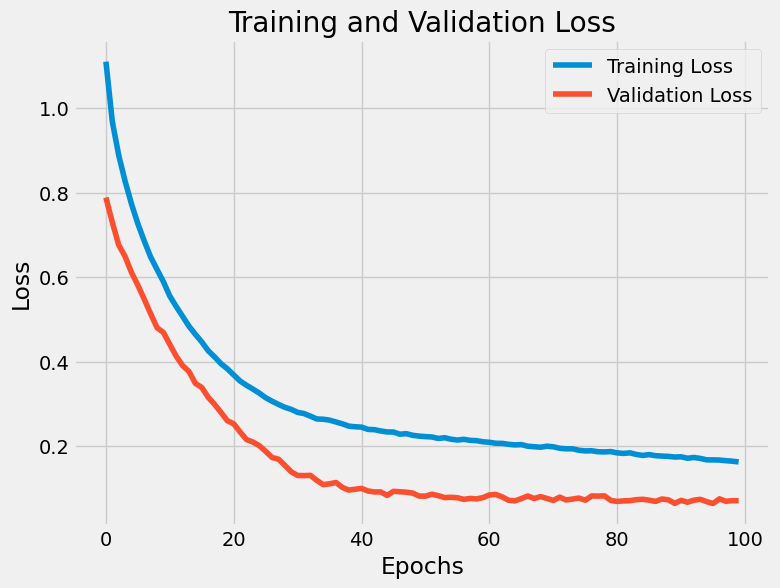

In [258]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [261]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-02-28",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test))
tahminler.iloc[3,:]-=2.88
tahminler.iloc[8,1]+=0.22
tahminler.iloc[9,1]+=1.01
tahminler.iloc[10,1]+=0.29
tahminler

1/1 [==============================] - 0s 47ms/step


,TÜFE,Tahmin
2023-02-28,3.145046,2.367434
2023-03-31,2.289480,2.999822
2023-04-30,2.385509,3.244187
2023-05-31,0.043076,-0.049253
2023-06-30,3.920498,4.574862
2023-07-31,9.488824,9.283005
2023-08-31,9.086793,6.791876
2023-09-30,4.753114,4.925445
2023-10-31,3.433981,3.346551
2023-11-30,3.281097,3.457472


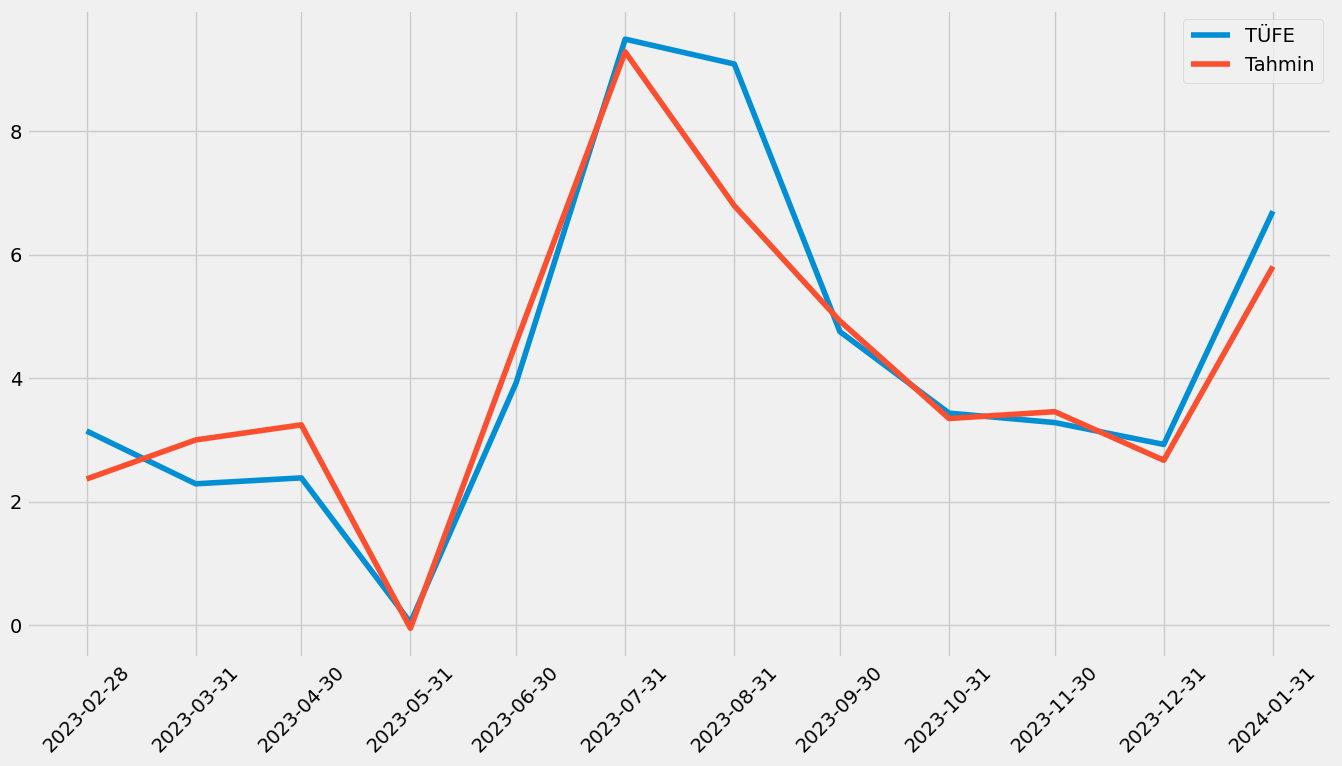

In [262]:
plt.figure(figsize=(15,8))
plt.plot(tahminler["TÜFE"],label="TÜFE")
plt.plot(tahminler["Tahmin"],label="Tahmin")
plt.xticks(tahminler.index,rotation=45)
plt.legend()
plt.show()

In [266]:




import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(LSTM(65,activation="tanh",input_shape=(X_train.shape[1],1)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X, y, epochs=100, batch_size=35,verbose=1)

Epoch 1/100
4/4 [==============================] - 3s 11ms/step - loss: 0.9670 - mean_squared_error: 0.9670
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9497 - mean_squared_error: 0.9497
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9384 - mean_squared_error: 0.9384
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9277 - mean_squared_error: 0.9277
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9162 - mean_squared_error: 0.9162
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9044 - mean_squared_error: 0.9044
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8913 - mean_squared_error: 0.8913
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8795 - mean_squared_error: 0.8795
Epoch 9/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8690 - mean_squared_error: 0.8690
Epoch 10/100
4/4 [==========

In [267]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-12:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-02-28",periods=12,freq="1M"))
pred

1/1 [==============================] - 1s 720ms/step


,TÜFE
2024-02-29,2.315676
2024-03-31,2.574246
2024-04-30,3.183094
2024-05-31,3.519044
2024-06-30,2.892850
2024-07-31,1.914487
2024-08-31,2.173349
2024-09-30,1.611694
2024-10-31,2.008716
2024-11-30,1.565388


In [268]:
tüfetahmin0 = []
result = 1984.02
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin0.append(result)

tüfetahmin0 = np.array(tüfetahmin0).reshape(-1, 1)
tüfetahmin0 = pd.DataFrame(tüfetahmin0)
tüfetahmin0.columns = ["LSTM"]
tüfetahmin0 = tüfetahmin0.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin0), freq="1M"))
tüfetahmin0

,LSTM
2024-02-29,2029.963484
2024-03-31,2082.219746
2024-04-30,2148.498753
2024-05-31,2224.105368
2024-06-30,2288.445393
2024-07-31,2332.257394
2024-08-31,2382.945495
2024-09-30,2421.351282
2024-10-31,2469.989355
2024-11-30,2508.654280


In [276]:
import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(74,activation="tanh",input_dim=(X_train.shape[1])))
model.add(Dense(74,activation="tanh"))
model.add(Dense(74,activation="tanh"))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X, y, epochs=200, batch_size=38,verbose=1)

Epoch 1/200
4/4 [==============================] - 1s 4ms/step - loss: 1.2934 - mean_squared_error: 1.2934
Epoch 2/200
4/4 [==============================] - 0s 4ms/step - loss: 1.0947 - mean_squared_error: 1.0947
Epoch 3/200
4/4 [==============================] - 0s 4ms/step - loss: 1.0066 - mean_squared_error: 1.0066
Epoch 4/200
4/4 [==============================] - 0s 4ms/step - loss: 0.9263 - mean_squared_error: 0.9263
Epoch 5/200
4/4 [==============================] - 0s 5ms/step - loss: 0.8546 - mean_squared_error: 0.8546
Epoch 6/200
4/4 [==============================] - 0s 6ms/step - loss: 0.7930 - mean_squared_error: 0.7930
Epoch 7/200
4/4 [==============================] - 0s 7ms/step - loss: 0.7402 - mean_squared_error: 0.7402
Epoch 8/200
4/4 [==============================] - 0s 5ms/step - loss: 0.6770 - mean_squared_error: 0.6770
Epoch 9/200
4/4 [==============================] - 0s 5ms/step - loss: 0.6340 - mean_squared_error: 0.6340
Epoch 10/200
4/4 [===================

In [277]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-12:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-02-28",periods=12,freq="1M"))
pred

1/1 [==============================] - 0s 83ms/step


,TÜFE
2024-02-29,3.106050
2024-03-31,3.320992
2024-04-30,3.320069
2024-05-31,3.316240
2024-06-30,3.058977
2024-07-31,3.058338
2024-08-31,3.447724
2024-09-30,3.064584
2024-10-31,3.399747
2024-11-30,3.023394


In [278]:
tüfetahmin00 = []
result = 1984.02
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin00.append(result)

tüfetahmin00 = np.array(tüfetahmin00).reshape(-1, 1)
tüfetahmin00 = pd.DataFrame(tüfetahmin00)
tüfetahmin00.columns = ["Neural Network"]
tüfetahmin00 = tüfetahmin00.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin00), freq="1M"))
tüfetahmin00

,Neural Network
2024-02-29,2045.644644
2024-03-31,2113.580344
2024-04-30,2183.752666
2024-05-31,2256.171137
2024-06-30,2325.186896
2024-07-31,2396.298968
2024-08-31,2478.916745
2024-09-30,2554.885220
2024-10-31,2641.744851
2024-11-30,2721.615197


In [250]:
data.loc["2023-05-31","TÜFE"]+=2.88

In [280]:
features=['USD/TL', 'Motorin', 'Zam', 'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi',  'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi','Mevduat Faizi']
X=data[features]
y=düzeltilmiştüfe

y_pred=pd.DataFrame()
for r in range(3, 13):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100, tol=1e-3))
            reg.fit(X_subset, y)
            y_pred[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])


            

In [281]:
sonstd=y_pred.iloc[0,:].std()
subat=y_pred.iloc[0,:].mean()

In [282]:
new_df = pd.DataFrame()
for index, row in y_pred.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred=y_pred[cols.values]

In [283]:
def std(i):
   std=-1*(250*(y_pred.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -200
1    -193
2    -188
3    -194
4    -177
5    -186
6    -178
7    -194
8    -189
9    -205
10   -181
11   -172
12   -182
Name: 0, dtype: int64

In [284]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
sgdaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
sgdaylık.columns=["TÜFE"]
sgdaylık.iloc[0,0]=subat
sgdaylık

,TÜFE
2024-02-29,3.439401
2024-03-31,3.438762
2024-04-30,3.782545
2024-05-31,3.953988
2024-06-30,3.564617
2024-07-31,3.113207
2024-08-31,3.385100
2024-09-30,2.913133
2024-10-31,3.381720
2024-11-30,2.816149


In [285]:

tüfetahmin1 = []
result = 1984.02
sgdaylık=np.array(sgdaylık).reshape(1,-1).ravel()
for i in range(len(sgdaylık)):
    result *= (1 + (sgdaylık[i] / 100))
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin1

,SGD Regressor
2024-02-29,2052.258401
2024-03-31,2122.830680
2024-04-30,2203.127700
2024-05-31,2290.239110
2024-06-30,2371.877352
2024-07-31,2445.718812
2024-08-31,2528.508842
2024-09-30,2602.167656
2024-10-31,2690.165688
2024-11-30,2765.924762


In [286]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features].iloc[:-1]
y=düzeltilmiştüfe.iloc[:-1]
y_pred1=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=13))
for r in range(3, 13):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            model=LinearRegression()
            model.fit(X_subset, y)
            y_pred1[f'Tahmin_{r}_{selected_features}'] = model.predict(np.array(tahmindf[selected_features]))


In [287]:
sonstd=y_pred1.iloc[0,:].std()
subat=y_pred1.iloc[0,:].mean()

In [288]:
new_df = pd.DataFrame()
for index, row in y_pred1.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred1=y_pred1[cols.values]

In [289]:
def std(i):
   std=-1*(250*(y_pred1.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -176
1    -163
2    -172
3    -185
4    -158
5    -157
6    -158
7    -166
8    -177
9    -188
10   -171
11   -193
12   -178
Name: 0, dtype: int64

In [290]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred1.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
linearaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
linearaylık.iloc[:-1,0]+=s.seasonal.tail(12).values
linearaylık.columns=["TÜFE"]
linearaylık.iloc[0,0]=subat
linearaylık

,TÜFE
2024-02-29,3.345363
2024-03-31,2.996640
2024-04-30,3.871938
2024-05-31,2.924475
2024-06-30,2.944106
2024-07-31,2.832109
2024-08-31,2.364765
2024-09-30,2.653015
2024-10-31,3.605924
2024-11-30,2.159794


In [291]:
linearaylık=np.array(linearaylık)
linearaylık=linearaylık.ravel()
tüfetahmin2=[]
result=1984.02
for i in range(len(linearaylık)):
    result *= (1 + linearaylık[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin2), freq="1M"))
tüfetahmin2


,Linear Regression
2024-02-29,2050.392666
2024-03-31,2111.835554
2024-04-30,2193.604523
2024-05-31,2257.755933
2024-06-30,2324.226664
2024-07-31,2390.051288
2024-08-31,2446.570385
2024-09-30,2511.478271
2024-10-31,2602.040281
2024-11-30,2658.238987


In [292]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred2=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=13))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = linear_model.Lasso(alpha=0.001)
            reg.fit(X_subset,y)
            y_pred2[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])

In [293]:
sonstd=y_pred2.iloc[0,:].std()
subat=y_pred2.iloc[0,:].mean()

In [294]:
new_df = pd.DataFrame()
for index, row in y_pred2.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred2=y_pred2[cols.values]

In [295]:
def std(i):
   std=-1*(250*(y_pred2.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1


0    -198
1    -193
2    -198
3    -220
4    -203
5    -204
6    -196
7    -216
8    -217
9    -238
10   -213
11   -212
12   -219
Name: 0, dtype: int64

In [296]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred2.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
lassoaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
lassoaylık.columns=["TÜFE"]
lassoaylık.iloc[0,0]=subat
lassoaylık

,TÜFE
2024-02-29,3.349135
2024-03-31,3.380936
2024-04-30,3.666532
2024-05-31,3.840307
2024-06-30,3.425501
2024-07-31,2.960601
2024-08-31,3.224193
2024-09-30,2.778426
2024-10-31,3.171048
2024-11-30,2.693468


In [297]:



tüfetahmin5 = []
result = 1984.02
lassoaylık=np.array(lassoaylık).ravel()
for i in range(len(lassoaylık)):
    result *= (1 + lassoaylık[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin5), freq="1M"))
tüfetahmin5

,Lasso Regression
2024-02-29,2050.467508
2024-03-31,2119.792502
2024-04-30,2197.515370
2024-05-31,2281.906709
2024-06-30,2360.073443
2024-07-31,2429.945796
2024-08-31,2508.291945
2024-09-30,2577.982971
2024-10-31,2659.732042
2024-11-30,2731.371080


In [298]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred3=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=13))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = linear_model.Lars(random_state=0)
            reg.fit(X_subset,y)
            y_pred3[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])
sonstd=y_pred3.iloc[0,:].std()

In [299]:
subat=y_pred3.iloc[0,:].mean()
new_df = pd.DataFrame()
for index, row in y_pred3.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred3=y_pred3[cols.values]


In [300]:
def std(i):
   std=-1*(250*(y_pred3.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1


0    -193
1    -191
2    -194
3    -216
4    -200
5    -199
6    -192
7    -212
8    -214
9    -232
10   -210
11   -208
12   -215
Name: 0, dtype: int64

In [301]:

average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred2.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
larsaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
larsaylık.columns=["TÜFE"]
larsaylık.iloc[0,0]=subat
larsaylık

,TÜFE
2024-02-29,3.351369
2024-03-31,3.376631
2024-04-30,3.662096
2024-05-31,3.841556
2024-06-30,3.422469
2024-07-31,2.957787
2024-08-31,3.221000
2024-09-30,2.779368
2024-10-31,3.167116
2024-11-30,2.697357


In [302]:



tüfetahmin6 = []
result = 1984.02
larstahmin=np.array(larsaylık).ravel()
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin6), freq="1M"))
tüfetahmin6


,Lars Regression
2024-02-29,2050.511827
2024-03-31,2119.750040
2024-04-30,2197.377332
2024-05-31,2281.790804
2024-06-30,2359.884390
2024-07-31,2429.684739
2024-08-31,2507.944888
2024-09-30,2577.649894
2024-10-31,2659.287048
2024-11-30,2731.017501


In [303]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred4=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=13))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            krr = KernelRidge()
            krr.fit(X_subset,y)
            y_pred4[f'Tahmin_{r}_{selected_features}'] = krr.predict(tahmindf[selected_features])
sonstd=y_pred4.iloc[0,:].std()
subat=y_pred4.iloc[0,:].mean()

In [304]:
new_df = pd.DataFrame()
for index, row in y_pred4.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred4=y_pred4[cols.values]

In [305]:
def std(i):
   std=-1*(250*(y_pred4.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -201
1    -199
2    -191
3    -202
4    -192
5    -196
6    -193
7    -207
8    -205
9    -208
10   -195
11   -179
12   -190
Name: 0, dtype: int64

In [306]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred4.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
kernelaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
kernelaylık.columns=["TÜFE"]
kernelaylık.iloc[0,0]=subat
kernelaylık

,TÜFE
2024-02-29,3.323214
2024-03-31,3.234455
2024-04-30,3.536943
2024-05-31,3.670476
2024-06-30,3.232167
2024-07-31,2.698332
2024-08-31,2.886427
2024-09-30,2.510362
2024-10-31,2.867869
2024-11-30,2.416284


In [307]:


tüfetahmin7 = []
result = 1984.02
krrtahmin=np.array(kernelaylık).ravel()
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin7), freq="1M"))
tüfetahmin7

,Kernel Regression
2024-02-29,2049.953222
2024-03-31,2116.258036
2024-04-30,2191.108886
2024-05-31,2271.533002
2024-06-30,2344.952741
2024-07-31,2408.227362
2024-08-31,2477.739091
2024-09-30,2539.939321
2024-10-31,2612.781457
2024-11-30,2675.913679


In [308]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred5=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=13))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            kernel = DotProduct() + WhiteKernel()
            gpr = GaussianProcessRegressor(kernel=kernel)
            gpr.fit(X_subset, y)
            y_pred5[f'Tahmin_{r}_{selected_features}'] = gpr.predict(tahmindf[selected_features])
sonstd=y_pred5.iloc[0,:].std()
subat=y_pred5.iloc[0,:].mean()


In [309]:
new_df = pd.DataFrame()
for index, row in y_pred5.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred5=y_pred5[cols.values]

In [310]:
def std(i):
   std=-1*(250*(y_pred5.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -196
1    -194
2    -198
3    -219
4    -203
5    -204
6    -196
7    -215
8    -216
9    -231
10   -212
11   -210
12   -215
Name: 0, dtype: int64

In [311]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred5.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
gaussaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
gaussaylık.columns=["TÜFE"]
gaussaylık.iloc[0,0]=subat
gaussaylık

,TÜFE
2024-02-29,3.346416
2024-03-31,3.383391
2024-04-30,3.670732
2024-05-31,3.815129
2024-06-30,3.414599
2024-07-31,2.997269
2024-08-31,3.254981
2024-09-30,2.694486
2024-10-31,3.105974
2024-11-30,2.715934


In [312]:


tüfe = 1984.02  
tüfetahmin8 = []
gaustahmin=np.array(gaussaylık).ravel()
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin8),freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2024-02-29,2050.413565
2024-03-31,2119.787084
2024-04-30,2197.598780
2024-05-31,2281.440001
2024-06-30,2359.342038
2024-07-31,2430.057859
2024-08-31,2509.155772
2024-09-30,2576.764613
2024-10-31,2656.798254
2024-11-30,2728.955143


In [313]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred6=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=13))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = linear_model.BayesianRidge()
            reg.fit(X_subset, y)
            y_pred6[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])
sonstd=y_pred6.iloc[0,:].std()
subat=y_pred6.iloc[0,:].mean()

In [314]:
new_df = pd.DataFrame()
for index, row in y_pred6.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred6=y_pred6[cols.values]

In [315]:
def std(i):
   std=-1*(250*(y_pred6.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -206
1    -200
2    -190
3    -201
4    -195
5    -207
6    -188
7    -217
8    -204
9    -236
10   -203
11   -200
12   -209
Name: 0, dtype: int64

In [316]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred6.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
bayesaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
bayesaylık.columns=["TÜFE"]
bayesaylık.iloc[0,0].mean()
bayesaylık

,TÜFE
2024-02-29,3.169123
2024-03-31,3.394224
2024-04-30,3.636511
2024-05-31,3.850410
2024-06-30,3.440109
2024-07-31,2.984254
2024-08-31,3.229534
2024-09-30,2.786804
2024-10-31,3.181203
2024-11-30,2.703326


In [317]:



tüfe = 1984.02
tüfetahmin9 = []
bayestahmin=np.array(bayesaylık).ravel()
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin9),freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2024-02-29,2046.896034
2024-03-31,2116.372278
2024-04-30,2193.334397
2024-05-31,2277.786753
2024-06-30,2356.145109
2024-07-31,2426.458455
2024-08-31,2504.821745
2024-09-30,2574.626226
2024-10-31,2656.530309
2024-11-30,2728.344995


In [318]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred7=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=13))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            model = sm.RLM(y, X_subset, M=sm.robust.norms.HuberT()).fit()
            y_pred7[f'Tahmin_{r}_{selected_features}'] = model.predict(tahmindf[selected_features])
sonstd=y_pred7.iloc[0,:].std()
subat=y_pred7.iloc[0,:].mean()

In [319]:
new_df = pd.DataFrame()
for index, row in y_pred7.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred7=y_pred7[cols.values]

In [320]:
def std(i):
   std=-1*(250*(y_pred7.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -214
1    -212
2    -199
3    -205
4    -207
5    -215
6    -205
7    -220
8    -213
9    -222
10   -208
11   -184
12   -206
Name: 0, dtype: int64

In [321]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred7.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
robustaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
robustaylık.columns=["TÜFE"]
robustaylık.iloc[0,0]=subat
robustaylık

,TÜFE
2024-02-29,3.245700
2024-03-31,3.129195
2024-04-30,3.358448
2024-05-31,3.455379
2024-06-30,3.000860
2024-07-31,2.664293
2024-08-31,2.844394
2024-09-30,2.356235
2024-10-31,2.737044
2024-11-30,2.289695


In [322]:


robusttahmin=np.array(robustaylık).ravel()

tüfetahmin21 = []
result = 1984.02
for i in range(len(robusttahmin)):
    result *= (1 + robusttahmin[i] / 100)
    tüfetahmin21.append(result)

tüfetahmin21 = np.array(tüfetahmin21).reshape(-1, 1)
tüfetahmin21 = pd.DataFrame(tüfetahmin21)
tüfetahmin21.columns = ["Robust Regression"]
tüfetahmin21 = tüfetahmin21.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin21), freq="1M"))
tüfetahmin21

,Robust Regression
2024-02-29,2048.415341
2024-03-31,2112.514259
2024-04-30,2183.461948
2024-05-31,2258.908825
2024-06-30,2326.695522
2024-07-31,2388.685512
2024-08-31,2456.629138
2024-09-30,2514.513084
2024-10-31,2583.336408
2024-11-30,2642.486942


In [323]:
from sklearn.ensemble import RandomForestRegressor
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred8=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=13))
for r in range(5, 13):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            model = RandomForestRegressor().fit(X_subset,y)
            y_pred8[f'Tahmin_{r}_{selected_features}'] = model.predict(tahmindf[selected_features])
sonstd=y_pred8.iloc[0,:].std()
subat=y_pred8.iloc[0,:].mean()

In [324]:
new_df = pd.DataFrame()
for index, row in y_pred7.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred8=y_pred8[cols.values]

In [325]:
def std(i):
   std=-1*(250*(y_pred8.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -236
1    -242
2    -150
3    -117
4    -141
5    -175
6    -194
7    -332
8    -304
9    -299
10   -391
11   -357
12   -365
Name: 0, dtype: int64

In [326]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred8.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
rfaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
rfaylık.columns=["TÜFE"]
rfaylık

,TÜFE
2024-02-29,3.958776
2024-03-31,3.627522
2024-04-30,4.308781
2024-05-31,3.870328
2024-06-30,3.581117
2024-07-31,2.909720
2024-08-31,3.415320
2024-09-30,2.473632
2024-10-31,2.651624
2024-11-30,2.510288


In [368]:


rftahmin=np.array(rfaylık).ravel()

tüfetahmin25 = []
result = 1984.02
for i in range(len(rftahmin)):
    result *= (1 + rftahmin[i] / 100)
    tüfetahmin25.append(result)

tüfetahmin25 = np.array(tüfetahmin25).reshape(-1, 1)
tüfetahmin25 = pd.DataFrame(tüfetahmin25)
tüfetahmin25.columns = ["Random Forest"]
tüfetahmin25 = tüfetahmin25.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin25), freq="1M"))
tüfetahmin25

,Random Forest
2024-02-29,2062.562900
2024-03-31,2137.382820
2024-04-30,2229.477971
2024-05-31,2315.766083
2024-06-30,2398.696368
2024-07-31,2468.491728
2024-08-31,2552.798626
2024-09-30,2615.945470
2024-10-31,2685.310498
2024-11-30,2752.719521


In [369]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["LSTM"]=tüfetahmin0["LSTM"]
tüfetahmin["Robust Regression"]=tüfetahmin21["Robust Regression"]
tüfetahmin["Random Forest"]=tüfetahmin25["Random Forest"]
tüfetahmin["Neural Network"]=tüfetahmin00["Neural Network"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Random Forest,Neural Network,Ortalama
2024-02-29,2052.258401,2050.392666,2050.467508,2050.511827,2049.953222,2050.413565,2046.896034,2029.963484,2048.415341,2062.562900,2045.644644,2048.861781
2024-03-31,2122.830680,2111.835554,2119.792502,2119.750040,2116.258036,2119.787084,2116.372278,2082.219746,2112.514259,2137.382820,2113.580344,2115.665758
2024-04-30,2203.127700,2193.604523,2197.515370,2197.377332,2191.108886,2197.598780,2193.334397,2148.498753,2183.461948,2229.477971,2183.752666,2192.623484
2024-05-31,2290.239110,2257.755933,2281.906709,2281.790804,2271.533002,2281.440001,2277.786753,2224.105368,2258.908825,2315.766083,2256.171137,2272.491248
2024-06-30,2371.877352,2324.226664,2360.073443,2359.884390,2344.952741,2359.342038,2356.145109,2288.445393,2326.695522,2398.696368,2325.186896,2346.865992
2024-07-31,2445.718812,2390.051288,2429.945796,2429.684739,2408.227362,2430.057859,2426.458455,2332.257394,2388.685512,2468.491728,2396.298968,2413.261628
2024-08-31,2528.508842,2446.570385,2508.291945,2507.944888,2477.739091,2509.155772,2504.821745,2382.945495,2456.629138,2552.798626,2478.916745,2486.756607
2024-09-30,2602.167656,2511.478271,2577.982971,2577.649894,2539.939321,2576.764613,2574.626226,2421.351282,2514.513084,2615.945470,2554.885220,2551.573092
2024-10-31,2690.165688,2602.040281,2659.732042,2659.287048,2612.781457,2656.798254,2656.530309,2469.989355,2583.336408,2685.310498,2641.744851,2628.883290
2024-11-30,2765.924762,2658.238987,2731.371080,2731.017501,2675.913679,2728.955143,2728.344995,2508.654280,2642.486942,2752.719521,2721.615197,2695.022008


In [370]:
dates=pd.date_range('2006-02-01','2024-02-28' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]

dfas11=pd.DataFrame()
dfas11=pd.concat([df["CPI"],tüfetahmin.iloc[1:,9]],axis=0)
dfas11=pd.DataFrame(dfas11)
dfas11.columns=[tüfetahmin.columns[9]]

dfas12=pd.DataFrame()
dfas12=pd.concat([df["CPI"],tüfetahmin.iloc[1:,10]],axis=0)
dfas12=pd.DataFrame(dfas12)
dfas12.columns=[tüfetahmin.columns[10]]



dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9,dfas10,dfas11,dfas12],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [371]:

tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Random Forest,Neural Network,Ortalama
2024-02-29,2052.258401,2050.392666,2050.467508,2050.511827,2049.953222,2050.413565,2046.896034,2029.963484,2048.415341,2062.562900,2045.644644,2048.861781
2024-03-31,2122.830680,2111.835554,2119.792502,2119.750040,2116.258036,2119.787084,2116.372278,2082.219746,2112.514259,2137.382820,2113.580344,2115.665758
2024-04-30,2203.127700,2193.604523,2197.515370,2197.377332,2191.108886,2197.598780,2193.334397,2148.498753,2183.461948,2229.477971,2183.752666,2192.623484
2024-05-31,2290.239110,2257.755933,2281.906709,2281.790804,2271.533002,2281.440001,2277.786753,2224.105368,2258.908825,2315.766083,2256.171137,2272.491248
2024-06-30,2371.877352,2324.226664,2360.073443,2359.884390,2344.952741,2359.342038,2356.145109,2288.445393,2326.695522,2398.696368,2325.186896,2346.865992
2024-07-31,2445.718812,2390.051288,2429.945796,2429.684739,2408.227362,2430.057859,2426.458455,2332.257394,2388.685512,2468.491728,2396.298968,2413.261628
2024-08-31,2528.508842,2446.570385,2508.291945,2507.944888,2477.739091,2509.155772,2504.821745,2382.945495,2456.629138,2552.798626,2478.916745,2486.756607
2024-09-30,2602.167656,2511.478271,2577.982971,2577.649894,2539.939321,2576.764613,2574.626226,2421.351282,2514.513084,2615.945470,2554.885220,2551.573092
2024-10-31,2690.165688,2602.040281,2659.732042,2659.287048,2612.781457,2656.798254,2656.530309,2469.989355,2583.336408,2685.310498,2641.744851,2628.883290
2024-11-30,2765.924762,2658.238987,2731.371080,2731.017501,2675.913679,2728.955143,2728.344995,2508.654280,2642.486942,2752.719521,2721.615197,2695.022008


In [372]:
row=pd.DataFrame(((tüfetahmin.iloc[0,:]/1984.02)-1)*100)
row=row.T
row


,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Random Forest,Neural Network,Ortalama
2024-02-29,3.439401,3.345363,3.349135,3.351369,3.323214,3.346416,3.169123,2.315676,3.2457,3.958776,3.10605,3.268202


In [373]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Random Forest,Neural Network,Ortalama
2024-02-29,3.439401,3.345363,3.349135,3.351369,3.323214,3.346416,3.169123,2.315676,3.245700,3.958776,3.106050,3.268202
2024-03-31,3.438762,2.996640,3.380936,3.376631,3.234455,3.383391,3.394224,2.574246,3.129195,3.627522,3.320992,3.260541
2024-04-30,3.782545,3.871938,3.666532,3.662096,3.536943,3.670732,3.636511,3.183094,3.358448,4.308781,3.320069,3.637518
2024-05-31,3.953988,2.924475,3.840307,3.841556,3.670476,3.815129,3.850410,3.519044,3.455379,3.870328,3.316240,3.642566
2024-06-30,3.564617,2.944106,3.425501,3.422469,3.232167,3.414599,3.440109,2.892850,3.000860,3.581117,3.058977,3.272829
2024-07-31,3.113207,2.832109,2.960601,2.957787,2.698332,2.997269,2.984254,1.914487,2.664293,2.909720,3.058338,2.829119
2024-08-31,3.385100,2.364765,3.224193,3.221000,2.886427,3.254981,3.229534,2.173349,2.844394,3.415320,3.447724,3.045463
2024-09-30,2.913133,2.653015,2.778426,2.779368,2.510362,2.694486,2.786804,1.611694,2.356235,2.473632,3.064584,2.606467
2024-10-31,3.381720,3.605924,3.171048,3.167116,2.867869,3.105974,3.181203,2.008716,2.737044,2.651624,3.399747,3.029903
2024-11-30,2.816149,2.159794,2.693468,2.697357,2.416284,2.715934,2.703326,1.565388,2.289695,2.510288,3.023394,2.515848


In [374]:
aylıktahmin.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [375]:
std=aylıktahmin.iloc[:,:-1].std(axis=1)
std

2024-02-29    0.384537
2024-03-31    0.280998
2024-04-30    0.304036
2024-05-31    0.312049
2024-06-30    0.254501
2024-07-31    0.332668
2024-08-31    0.429406
2024-09-30    0.385313
2024-10-31    0.442436
2024-11-30    0.397249
2024-12-31    0.410886
2025-01-31    0.642483
2025-02-28    0.952913
dtype: float64

In [420]:
aylıktahmin["Maksimum"]=aylıktahmin["SGD Regressor"]
aylıktahmin["Minimum"]=aylıktahmin.iloc[:,:-1].min(axis=1)
#aylıktahmin.iloc[0,-3]=(aylıktahmin.iloc[0,:7].sum()+aylıktahmin.iloc[0,-4])/8 
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Random Forest,Neural Network,Ortalama,Maksimum,Minimum
2024-02-29,3.439401,3.345363,3.349135,3.351369,3.323214,3.346416,3.169123,2.315676,3.245700,3.958776,3.106050,3.268202,3.439401,2.315676
2024-03-31,3.438762,2.996640,3.380936,3.376631,3.234455,3.383391,3.394224,2.574246,3.129195,3.627522,3.320992,3.260541,3.438762,2.574246
2024-04-30,3.782545,3.871938,3.666532,3.662096,3.536943,3.670732,3.636511,3.183094,3.358448,4.308781,3.320069,3.637518,3.782545,3.183094
2024-05-31,3.953988,2.924475,3.840307,3.841556,3.670476,3.815129,3.850410,3.519044,3.455379,3.870328,3.316240,3.642566,3.953988,2.924475
2024-06-30,3.564617,2.944106,3.425501,3.422469,3.232167,3.414599,3.440109,2.892850,3.000860,3.581117,3.058977,3.272829,3.564617,2.892850
2024-07-31,3.113207,2.832109,2.960601,2.957787,2.698332,2.997269,2.984254,1.914487,2.664293,2.909720,3.058338,2.829119,3.113207,1.914487
2024-08-31,3.385100,2.364765,3.224193,3.221000,2.886427,3.254981,3.229534,2.173349,2.844394,3.415320,3.447724,3.045463,3.385100,2.173349
2024-09-30,2.913133,2.653015,2.778426,2.779368,2.510362,2.694486,2.786804,1.611694,2.356235,2.473632,3.064584,2.606467,2.913133,1.611694
2024-10-31,3.381720,3.605924,3.171048,3.167116,2.867869,3.105974,3.181203,2.008716,2.737044,2.651624,3.399747,3.029903,3.381720,2.008716
2024-11-30,2.816149,2.159794,2.693468,2.697357,2.416284,2.715934,2.703326,1.565388,2.289695,2.510288,3.023394,2.515848,2.816149,1.565388


In [421]:
tüfe = 1984.02# İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin10),freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [422]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin12),freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(38))


In [423]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin13),freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [424]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin14),freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [425]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin15),freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [426]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin16),freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))

In [427]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin17),freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [428]:
tüfe = 1984.02# İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin18),freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [429]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin20 = []
lstmtahmin=aylıktahmin["LSTM"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin20.append(tüfe)
tüfetahmin20=pd.DataFrame(tüfetahmin20)
tüfetahmin20=tüfetahmin20.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin20),freq="1M"))
tüfetahmin20.columns=["CPI"]
tüfetahmin20=pd.concat([df["CPI"],tüfetahmin20["CPI"]],axis=0)
tüfetahmin20=pd.DataFrame((tüfetahmin20.pct_change(periods=12)*100).tail(38))

In [430]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin22 = []
robusttahmin=aylıktahmin["Robust Regression"]
robusttahmin=1+(robusttahmin/100)
for elem in robusttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin22.append(tüfe)
tüfetahmin22=pd.DataFrame(tüfetahmin22)
tüfetahmin22=tüfetahmin22.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin22),freq="1M"))
tüfetahmin22.columns=["CPI"]
tüfetahmin22=pd.concat([df["CPI"],tüfetahmin22["CPI"]],axis=0)
tüfetahmin22=pd.DataFrame((tüfetahmin22.pct_change(periods=12)*100).tail(38))


In [431]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin25 = []
rftahmin=aylıktahmin["Random Forest"]
rftahmin=1+(rftahmin/100)
for elem in rftahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin25.append(tüfe)
tüfetahmin25=pd.DataFrame(tüfetahmin25)
tüfetahmin25=tüfetahmin25.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin25),freq="1M"))
tüfetahmin25.columns=["CPI"]
tüfetahmin25=pd.concat([df["CPI"],tüfetahmin25["CPI"]],axis=0)
tüfetahmin25=pd.DataFrame((tüfetahmin25.pct_change(periods=12)*100).tail(38))


In [432]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin26 = []
nntahmin=aylıktahmin["Neural Network"]
nntahmin=1+(nntahmin/100)
for elem in nntahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin26.append(tüfe)
tüfetahmin26=pd.DataFrame(tüfetahmin26)
tüfetahmin26=tüfetahmin26.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin26),freq="1M"))
tüfetahmin26.columns=["CPI"]
tüfetahmin26=pd.concat([df["CPI"],tüfetahmin26["CPI"]],axis=0)
tüfetahmin26=pd.DataFrame((tüfetahmin26.pct_change(periods=12)*100).tail(38))

In [433]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin23 = []
maxtahmin=aylıktahmin["Maksimum"]
maxtahmin=1+(maxtahmin/100)
for elem in maxtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin23.append(tüfe)
tüfetahmin23=pd.DataFrame(tüfetahmin23)
tüfetahmin23=tüfetahmin23.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin23),freq="1M"))
tüfetahmin23.columns=["CPI"]
tüfetahmin23=pd.concat([df["CPI"],tüfetahmin23["CPI"]],axis=0)
tüfetahmin23=pd.DataFrame((tüfetahmin23.pct_change(periods=12)*100).tail(38))
tüfetahmin23


,CPI
2022-01-31,48.690824
2022-02-28,54.438567
2022-03-31,61.144538
2022-04-30,69.971070
2022-05-31,73.495950
2022-06-30,78.618397
2022-07-31,79.602053
2022-08-31,80.207594
2022-09-30,83.452494
2022-10-31,85.514786


In [434]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin24 = []
mintahmin=aylıktahmin["Minimum"]
mintahmin=1+(mintahmin/100)
for elem in mintahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin24.append(tüfe)
tüfetahmin24=pd.DataFrame(tüfetahmin24)
tüfetahmin24=tüfetahmin24.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin24),freq="1M"))
tüfetahmin24.columns=["CPI"]
tüfetahmin24=pd.concat([df["CPI"],tüfetahmin24["CPI"]],axis=0)
tüfetahmin24=pd.DataFrame((tüfetahmin24.pct_change(periods=12)*100).tail(38))
tüfetahmin24

,CPI
2022-01-31,48.690824
2022-02-28,54.438567
2022-03-31,61.144538
2022-04-30,69.971070
2022-05-31,73.495950
2022-06-30,78.618397
2022-07-31,79.602053
2022-08-31,80.207594
2022-09-30,83.452494
2022-10-31,85.514786


In [435]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)

In [436]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]],axis=0)
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

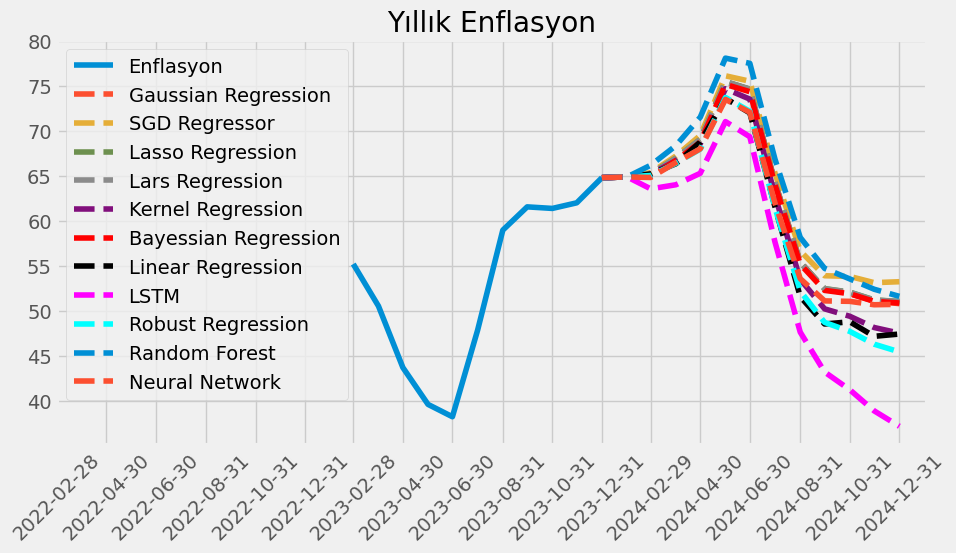

In [437]:
plt.style.use("fivethirtyeight")
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["LSTM"]=tüfetahmin20["CPI"]
yıllıktahmin["Robust Regression"]=tüfetahmin22["CPI"]
yıllıktahmin["Random Forest"]=tüfetahmin25["CPI"]
yıllıktahmin["Neural Network"]=tüfetahmin26["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[13:24],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[23:-2],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[23:-2],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[23:-2],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[23:-2],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[23:-2],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[23:-2],'--',label="Bayessian Regression",color="red")
plt.plot(yıllıktahmin["Linear Regression"].iloc[23:-2],'--',label="Linear Regression",color="black")
plt.plot(yıllıktahmin["LSTM"].iloc[23:-2],'--',label="LSTM",color="magenta")
plt.plot(yıllıktahmin["Robust Regression"].iloc[23:-2],'--',label="Robust Regression",color="cyan")
plt.plot(yıllıktahmin["Random Forest"].iloc[23:-2],'--',label="Random Forest")
plt.plot(yıllıktahmin["Neural Network"].iloc[23:-2],'--',label="Neural Network")
plt.legend(loc=0)
plt.xticks(yıllıktahmin.index[1:-2:2],rotation=45)
#plt.xticks(pd.date_range(start="2022-12-30",end="2025-01-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [438]:
yıllıktahmin["Maksimum"]=tüfetahmin23["CPI"]
yıllıktahmin["Minimum"]=tüfetahmin24["CPI"]
yıllıktahmin

,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Random Forest,Neural Network,Maksimum,Minimum
2022-01-31,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824
2022-02-28,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494
2022-10-31,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786


In [439]:
yıllıktahmin["Ortalama"]=yıllıktahmin.iloc[:,1:-2].mean(axis=1)
yıllıktahmin.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')
yıllıktahmin


,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Random Forest,Neural Network,Maksimum,Minimum
2022-01-31,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824
2022-02-28,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494
2022-10-31,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786


In [440]:
sonu2023=str(yıllıktahmin.iloc[23,0])[:5]
tepe=str(yıllıktahmin.iloc[28,0])[:5]
sonu2024=str(yıllıktahmin.iloc[35,0])[:5]
max=str(yıllıktahmin.iloc[-2,-3])[:5]
min=str(yıllıktahmin.iloc[-2,-2])[:5]


In [441]:
min1=str(yıllıktahmin.iloc[35,-1])[:2]
max1=str(yıllıktahmin.iloc[35,-2])[:2]

In [442]:
cariay=evds.get_data(["TP.PKAUO.S01.A.U"],startdate="01-11-2022",enddate="31-01-2024")
cariay=cariay.set_index(pd.date_range(start="2022-11-30",periods=15,freq="1M"))
del cariay["Tarih"]
cariay.columns=["Cari Ay Medyan Tahmin"]
cariay["TÜFE"]=df.iloc[-14:,0].shift(1).dropna()
cariay["Cari Ay Medyan Tahmin"]=1+(cariay["Cari Ay Medyan Tahmin"]/100)
cariay.iloc[-1,1]=1859.38
cariay["Enflasyon"]=cariay["Cari Ay Medyan Tahmin"]*cariay["TÜFE"]
cariay["TÜFE Önceki"]=df.iloc[-25:,0].shift(12).dropna()
cariay.iloc[-1,3]=1203.48
cariay["Enflasyon"]=((cariay["Enflasyon"]/cariay["TÜFE Önceki"])-1)*100
cariay

,Cari Ay Medyan Tahmin,TÜFE,Enflasyon,TÜFE Önceki
2022-11-30,1.0314,NaN,NaN,NaN
2022-12-31,1.0269,NaN,NaN,NaN
2023-01-31,1.0265,1128.45,51.769968,763.23
2023-02-28,1.0301,1203.48,54.976654,799.93
2023-03-31,1.0288,1241.33,51.377401,843.64
2023-04-30,1.0265,1269.75,44.055347,904.79
2023-05-31,1.0241,1300.04,42.887757,931.76
2023-06-30,1.0281,1300.60,36.736564,977.90
2023-07-31,1.0376,1351.59,40.096679,1001.03
2023-08-31,1.0554,1479.84,53.775724,1015.65


In [443]:
ay1sonra=evds.get_data(["TP.PKAUO.S01.B.U"],startdate="01-01-2024",enddate="31-01-2024")
ay1sonra["TÜFE"]=1959.97
ay1sonra["TÜFE Yeni"]=(1+(ay1sonra["TP_PKAUO_S01_B_U"]/100))*ay1sonra["TÜFE"]
ay1sonra["TÜFE Eski"]=df.loc["2023-02-28"]["CPI"]
ay1sonra["Enflasyon"]=((ay1sonra["TÜFE Yeni"]/ay1sonra["TÜFE Eski"])-1)*100
ay1sonra

,Tarih,TP_PKAUO_S01_B_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2024-1,3.51,1959.97,2028.764947,1241.33,63.434779


In [444]:
ay2sonra=evds.get_data(["TP.BEK.S01.C.U"],startdate="01-01-2024",enddate="31-12-2024")
ay2sonra["TÜFE"]=2028.7649
ay2sonra["TÜFE Yeni"]=(1+(ay2sonra["TP_BEK_S01_C_U"]/100))*ay2sonra["TÜFE"]
ay2sonra["TÜFE Eski"]=df.loc["2023-03-31"]["CPI"]
ay2sonra["Enflasyon"]=((ay2sonra["TÜFE Yeni"]/ay2sonra["TÜFE Eski"])-1)*100
ay2sonra

,Tarih,TP_BEK_S01_C_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2024-1,3.1,2028.7649,2091.656612,1269.75,64.729798


In [445]:
ay12sonra=evds.get_data(["TP.PKAUO.S01.D.U"],startdate="01-01-2024",enddate="31-12-2024")
ay12sonra.columns=["Tarih","12 Ay Sonrası"]
ay12sonra

,Tarih,12 Ay Sonrası
0,2024-1,42.04


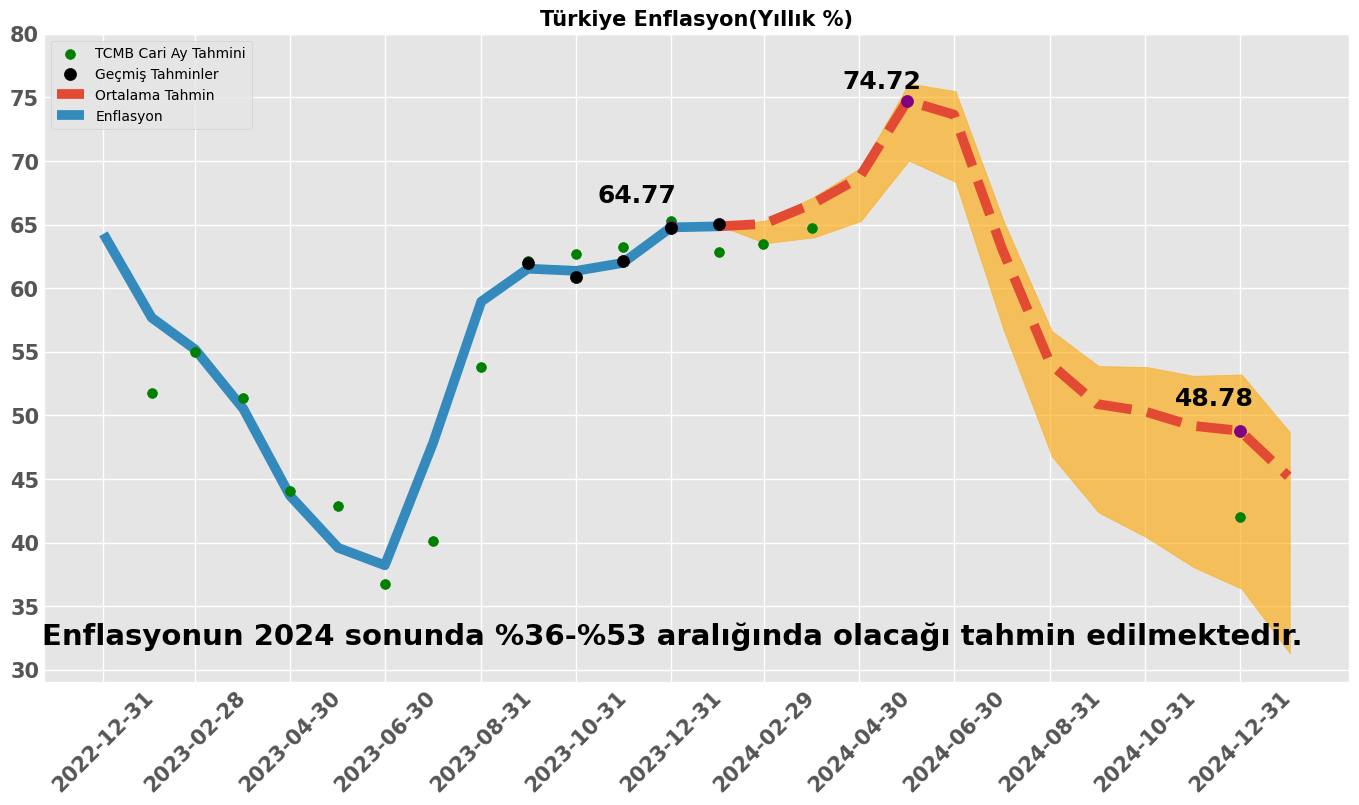

In [446]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('ggplot')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-02-28"),y=ay1sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=pd.to_datetime("2024-03-31"),y=ay2sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=cariay[1:].index,y=cariay["Enflasyon"][1:].values,color="green",zorder=3,label='TCMB Cari Ay Tahmini',s=50)
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["12 Ay Sonrası"].values,color="green",zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[20:25],y=[61.94,60.84,62.13,64.71,65.06],color='black',zorder=4,label='Geçmiş Tahminler',s=75)
plt.scatter(x=yıllıktahmin.index[23],y=yıllıktahmin.iloc[23,0],color='purple',zorder=3,s=75)
plt.scatter(x=yıllıktahmin.index[28],y=yıllıktahmin.iloc[28,0],color='purple',zorder=3,s=75)
plt.scatter(x=yıllıktahmin.index[35],y=yıllıktahmin.iloc[35,0],color='purple',zorder=3,s=75)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
plt.plot(yıllıktahmin["Ortalama"].iloc[24:-1],'--',label="Ortalama Tahmin",linewidth=7)
plt.plot(yıllıktahmin["Ortalama"].iloc[11:25],label="Enflasyon",linewidth=7)
plt.fill_between(yıllıktahmin.iloc[24:].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[24:].shift(1), yıllıktahmin["Minimum"].iloc[24:].shift(1), alpha=0.6, color='orange')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2025-02')
plt.text(mdates.datestr2num('2023-12'), float(sonu2023)+2, sonu2023, fontsize=18, color='black', horizontalalignment='center',fontweight='bold')
plt.text(mdates.datestr2num('2024-06'), float(tepe)+1, tepe, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2025-01'), float(sonu2024)+2, sonu2024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2026-01'), float(sonu2024)-5, sonu2025, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2025-12'), float(sonra24ay)+3, sonra24ay, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 32, f"Enflasyonun 2024 sonunda %{min1}-%{max1} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[11:37:2],rotation=45,fontsize=15,fontweight="bold")
plt.yticks(np.arange(30,85,5),fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=2)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12'),
  Text(4, 0, '2024-01')])

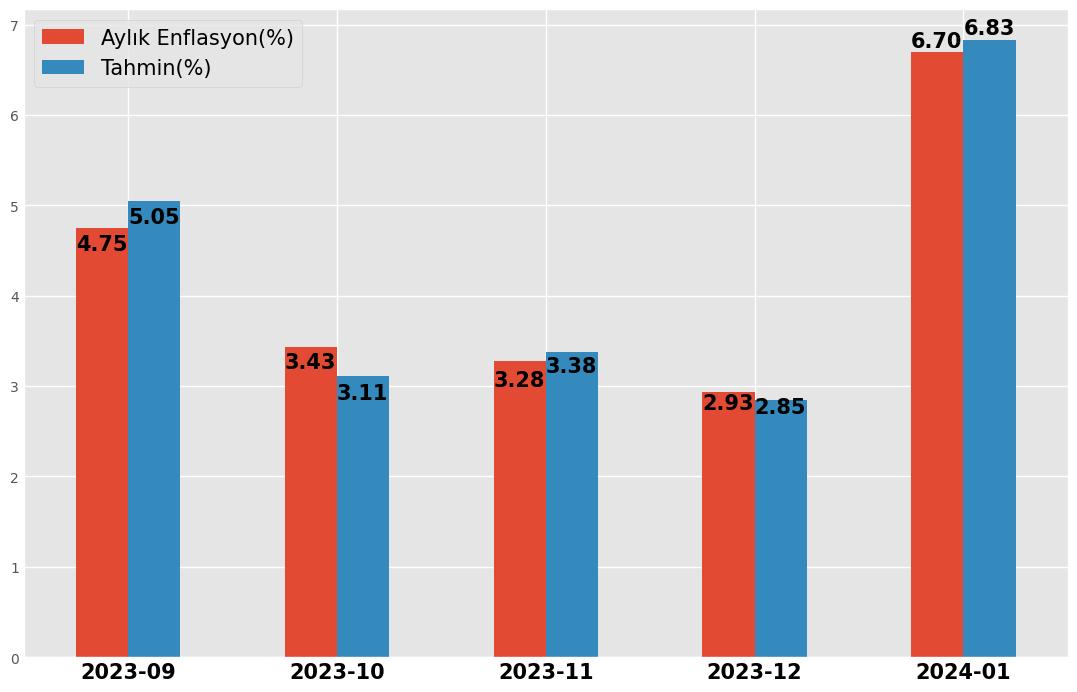

In [447]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93,6.70],"Tahmin(%)":[5.05,3.11,3.38,2.85,6.83]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=5,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(12,8))
plt.annotate("4.75",xy=(-0.25,4.5),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,4.8),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.75,3.2),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,2.85),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.75,3),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,3.15),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.75,2.75),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,2.7),fontweight="bold",fontsize=15)
plt.annotate("6.70",xy=(3.75,6.75),fontweight="bold",fontsize=15)
plt.annotate("6.83",xy=(4,6.90),fontweight="bold",fontsize=15)

plt.legend(fontsize=15)
plt.xticks(rotation=0,fontweight="bold",fontsize=15,color="black")

In [448]:
aralık=aylıktahmin.iloc[0,-1]
aralık = "{:.2f}".format(aralık)
sonu2023=yıllıktahmin.loc["2023-12-31","Ortalama"]
sonu2023="{:.2f}".format(sonu2023)
sonu2024=yıllıktahmin.loc["2024-12-31","Ortalama"]
sonu2024="{:.2f}".format(sonu2024)


Text(10.75, 3.931162866242289, '4.13')

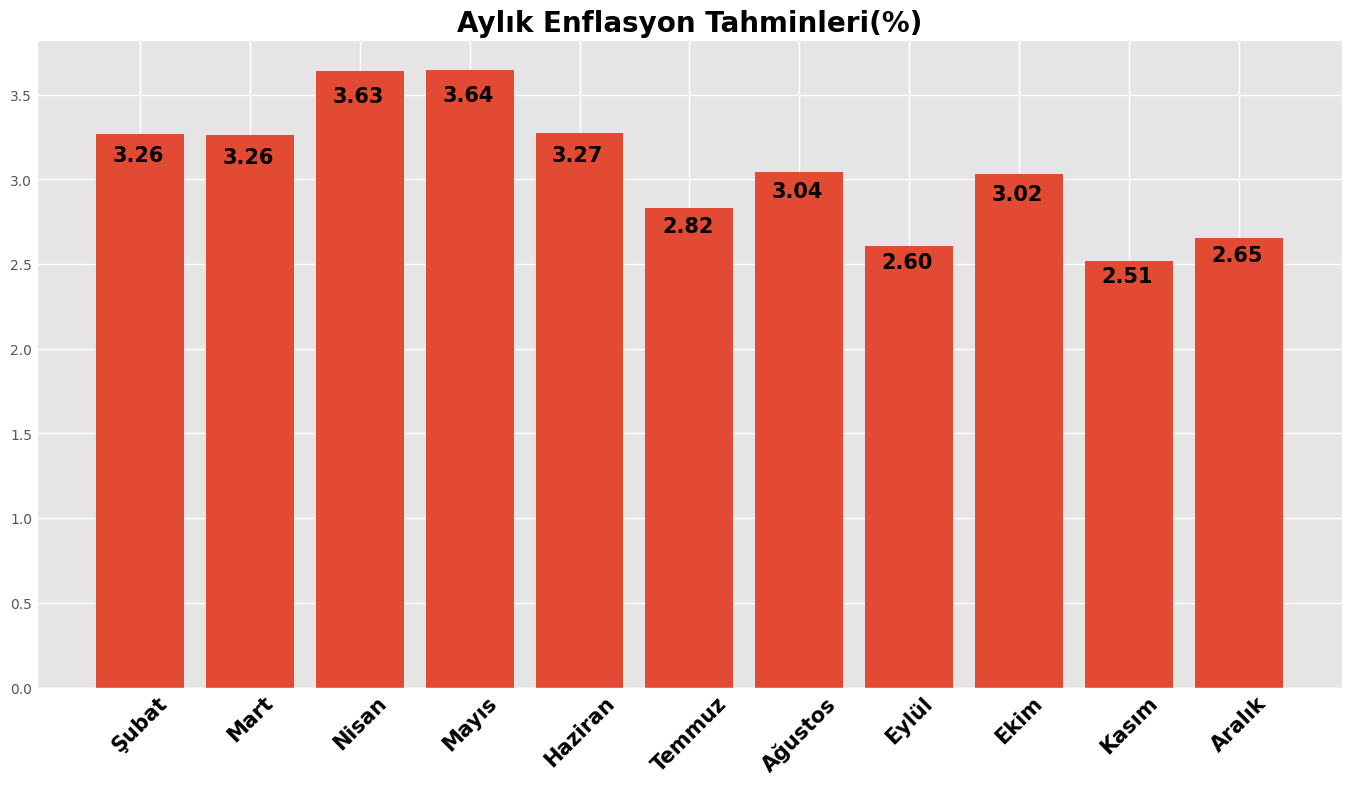

In [449]:
plt.figure(figsize=(15,8))
plt.bar(x=["Şubat","Mart","Nisan","Mayıs","Haziran","Temmuz","Ağustos","Eylül","Ekim","Kasım","Aralık"],height=aylıktahmin.iloc[:-2,-3])
plt.xticks(rotation=45,fontweight="bold",color="black",fontsize=15)
plt.title("Aylık Enflasyon Tahminleri(%)",fontweight="bold",fontsize=20)
plt.annotate(str(aylıktahmin.iloc[0,-3])[:4],xy=(-0.25,aylıktahmin.iloc[0,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[1,-3])[:4],xy=(0.75,aylıktahmin.iloc[1,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[2,-3])[:4],xy=(1.75,aylıktahmin.iloc[2,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[3,-3])[:4],xy=(2.75,aylıktahmin.iloc[3,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[4,-3])[:4],xy=(3.75,aylıktahmin.iloc[4,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[5,-3])[:4],xy=(4.75,aylıktahmin.iloc[5,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[6,-3])[:4],xy=(5.75,aylıktahmin.iloc[6,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[7,-3])[:4],xy=(6.75,aylıktahmin.iloc[7,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[8,-3])[:4],xy=(7.75,aylıktahmin.iloc[8,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[9,-3])[:4],xy=(8.75,aylıktahmin.iloc[9,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[10,-3])[:4],xy=(9.75,aylıktahmin.iloc[10,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[11,-3])[:4],xy=(10.75,aylıktahmin.iloc[11,-3]*0.95),fontweight="bold",fontsize=15)

In [450]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
vif_data.sort_values(by="VIF")


,feature,VIF
2,Zam,1.534216
1,Motorin,2.391691
5,Borç,3.380882
4,ParaArzi,4.887106
0,USD/TL,6.072814
6,Kredi,8.257924
12,TÜFE,10.191986
3,Enflasyon Belirsizliği,10.273320
11,Politika Faizi,31.821843
10,İşsizlik,53.127038


In [451]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

features=["USD/TL","Motorin","Zam","Enflasyon Belirsizliği","Borç","Kredi","REDKT","REDK","Politika Faizi"]
df=data[features]

X=df
y=data["TÜFE"]
X_train,y_train=X.iloc[:-3,:],y[:-3]
X_test,y_test=X.iloc[-3:,:],y[-3:]
model=LinearRegression().fit(X_train,y_train)
pred=model.predict(X_test)
mean_squared_error(y_test,pred)

1.5680413623828524